In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_absolute_percentage_error

from sklearn.impute import KNNImputer

In [2]:
data_folder = "data"
filename = "train.csv"
df = pd.read_csv(os.path.join("..", data_folder, filename), parse_dates=True, index_col="date")

### Make it an univariate timeseries

In [3]:
df_subset = df[["warehouse", "orders"]]
df_subset.head()

,warehouse,orders
date,,
2020-12-05,Prague_1,6895.0
2020-12-06,Prague_1,6584.0
2020-12-07,Prague_1,7030.0
2020-12-08,Prague_1,6550.0
2020-12-09,Prague_1,6910.0


In [4]:
Prague_1_test = df_subset[df_subset["warehouse"] == "Prague_1"].drop(columns=["warehouse"])

In [5]:
Prague_1_test.shape

(1193, 1)

In [6]:
def fill_missing_dates_and_values(df):
    """
    Look for missing dates and impute all values
    """
    # Ensure the DataFrame has a continuous date range index
    date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
    df = df.reindex(date_range)

    # Impute the missing dates
    imputer = KNNImputer(n_neighbors=2)
    imputed_data = imputer.fit_transform(df)

    # Create a DataFrame with the imputed data
    imputed_df = pd.DataFrame(data=imputed_data, columns=df.columns, index=df.index)

    return imputed_df

Prague_1_full_date_range = fill_missing_dates_and_values(Prague_1_test)
Prague_1_full_date_range.shape

(1197, 1)

In [7]:
Prague_1_full_date_range.reset_index(inplace=True)

### Prophet

In [8]:
# Rename columns
Prague_1_full_date_range.rename(columns={"index": "ds",
                              "orders": "y"}, inplace=True)
Prague_1_full_date_range

,ds,y
0,2020-12-05,6895.0
1,2020-12-06,6584.0
2,2020-12-07,7030.0
3,2020-12-08,6550.0
4,2020-12-09,6910.0
...,...,...
1192,2024-03-11,9866.0
1193,2024-03-12,9710.0
1194,2024-03-13,9628.0
1195,2024-03-14,10056.0


In [9]:
model = Prophet(weekly_seasonality=True, yearly_seasonality=True)

model.fit(Prague_1_full_date_range)


15:28:51 - cmdstanpy - INFO - Chain [1] start processing
15:28:51 - cmdstanpy - INFO - Chain [1] done processing


In [10]:
future = model.make_future_dataframe(periods=365)

forecast = model.predict(future)

/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


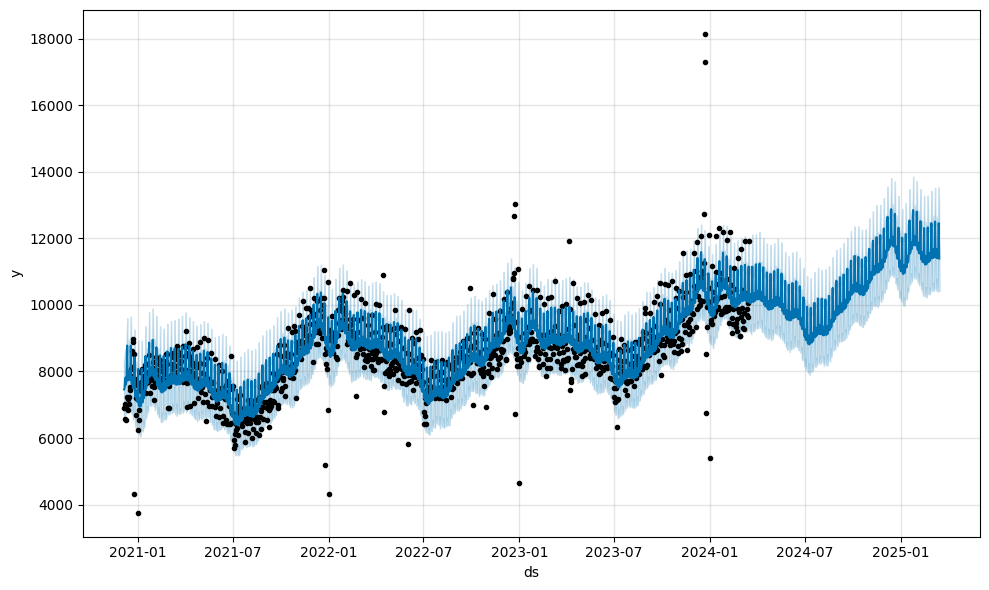

In [11]:
fig1 = model.plot(forecast)
plt.show()

## Test again with validation set

In [12]:
# Take the last year as validation data, as it has a yearly seasonality
split_time = len(Prague_1_full_date_range) - 365

In [13]:
Prague_1_full_date_range_train = Prague_1_full_date_range.iloc[:split_time, :]
Prague_1_full_date_range_val = Prague_1_full_date_range.iloc[split_time:, :]
print(len(Prague_1_full_date_range_train))
print(len(Prague_1_full_date_range_val))

832
365


### Important Holidays

In [14]:
# pre_christmas = pd.DataFrame({
#   'holiday': 'Christmas',
#   'ds': pd.to_datetime(['2021-12-23',
#                         '2022-12-23',
#                         '2023-12-23',
#                         '2024-12-23',]
#                        ),
#   'lower_window': 0,
#   'upper_window': 4,
# })

# new_year = pd.DataFrame({
#   'holiday': 'new_year',
#   'ds': pd.to_datetime(['2021-01-01',
#                         '2022-01-01',
#                         '2023-01-01',
#                         '2024-01-01',]
#                        ),
#   'lower_window': 0,
#   'upper_window': 1,
# })
# holidays = pd.concat((pre_christmas, new_year))

15:28:53 - cmdstanpy - INFO - Chain [1] start processing
15:28:53 - cmdstanpy - INFO - Chain [1] done processing
/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/marcel/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


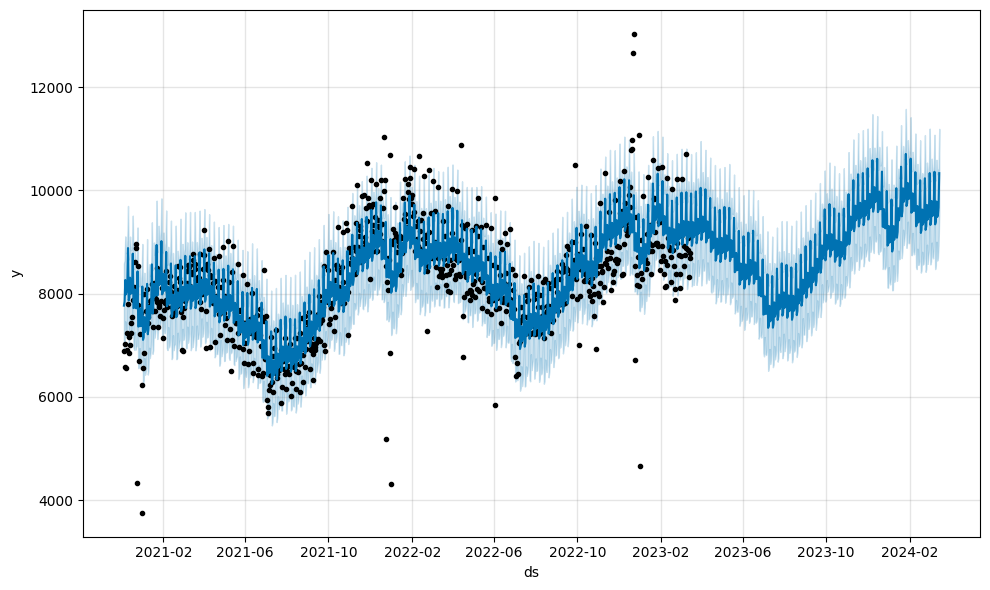

6.17097228253043

In [15]:
model_1 = Prophet(daily_seasonality=True,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  changepoint_prior_scale = 0.004,
                  seasonality_prior_scale = 0.2)#,
                  #holidays=holidays)

# model_1.add_country_holidays(country_name='CZ')

model_1.fit(Prague_1_full_date_range_train)

future = model_1.make_future_dataframe(periods=365)

forecast = model_1.predict(future)

fig1 = model_1.plot(forecast)
plt.show()

mean_absolute_percentage_error(Prague_1_full_date_range_val["y"], forecast["yhat"].iloc[split_time:]) * 100

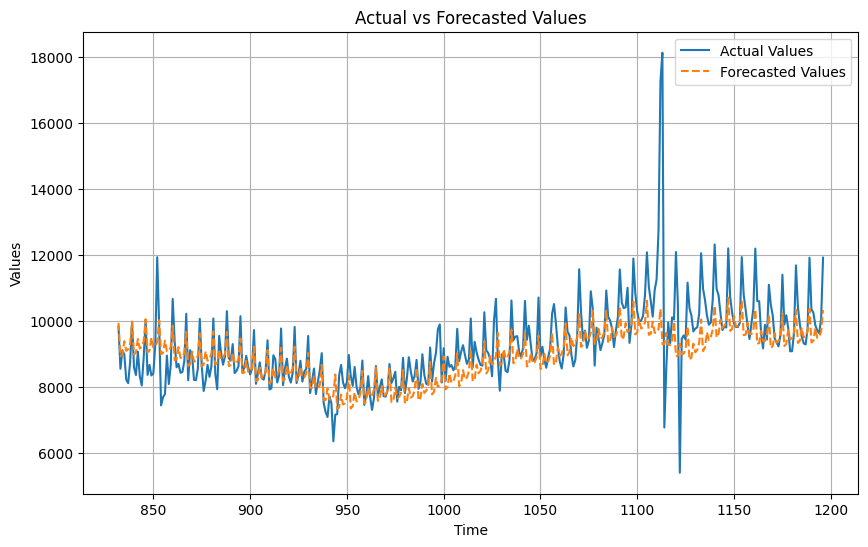

In [88]:
# y Werte für den Plot
y_values = Prague_1_full_date_range_val["y"]
yhat_values = forecast["yhat"].iloc[split_time:]

# Plot erstellen
plt.figure(figsize=(10, 6))
plt.plot(y_values, label='Actual Values')
plt.plot(yhat_values, label='Forecasted Values', linestyle='--')

# Plot-Details
plt.title('Actual vs Forecasted Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

# Plot anzeigen
plt.show()

### Where are the high peaks ?

In [89]:

Prague_1_full_date_range_val.loc[Prague_1_full_date_range_val["y"].idxmax(), :]

ds    2023-12-23 00:00:00
y                 18139.0
Name: 1113, dtype: object

### Christmas !!

## Hyperparameter tuning

In [36]:
from sklearn.model_selection import ParameterGrid

# Define the hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))


# Cross-validation function to calculate MAPE
def cross_validation_mape(model, df, initial, period, horizon):
    from prophet.diagnostics import cross_validation
    from prophet.diagnostics import performance_metrics

    df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)
    df_p = performance_metrics(df_cv, metrics=['mape'])
    return df_p['mape'].values[0]

list_of_result_dicts = []
list_of_scores = []
# Perform grid search
for params in all_params:

    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    m.fit(Prague_1_full_date_range)

    # Define the initial, period, and horizon for cross-validation
    initial = '365 days'
    period = '180 days'
    horizon = '365 days'

    # Compute MAPE using cross-validation
    mape = cross_validation_mape(m, Prague_1_full_date_range, initial, period, horizon)

    # Store the results
    list_of_result_dicts.append(params)
    list_of_scores.append(mape)

results = pd.DataFrame({"params": list_of_result_dicts,
                        "MAPE": list_of_scores})

# Find the best hyperparameters
best_params = results.loc[results['MAPE'].idxmin()]
print(f"Best parameters: {best_params}")


16:15:09 - cmdstanpy - INFO - Chain [1] start processing


[{'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}, {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}, {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 1.0}, {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 10.0}, {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}, {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.1}, {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 1.0}, {'changepoint_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'se

16:15:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:11 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing
16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:12 - cmdstanpy - INFO - Chain [1] done processing
16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:12 - cmdstanpy - INFO - Chain [1] done processing
16:15:12 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:13 - cmdstanpy - INFO - Chain [1] done processing
16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1] done processing
16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:14 - cmdstanpy - INFO - Chain [1] start processing
16:15:14 - cmdstanpy - INFO - Chain [1] done processing
16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:15 - cmdstanpy - INFO - Chain [1] start processing
16:15:15 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
16:15:16 - cmdstanpy - INFO - Chain [1] start processing
16:15:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:17 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1] done processing
16:15:17 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1] done processing
16:15:17 - cmdstanpy - INFO - Chain [1] start processing
16:15:17 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:18 - cmdstanpy - INFO - Chain [1] start processing
16:15:18 - cmdstanpy - INFO - Chain [1] done processing
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
16:15:19 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing
16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:20 - cmdstanpy - INFO - Chain [1] done processing
16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:20 - cmdstanpy - INFO - Chain [1] start processing
16:15:20 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:21 - cmdstanpy - INFO - Chain [1] start processing
16:15:21 - cmdstanpy - INFO - Chain [1] done processing
16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:22 - cmdstanpy - INFO - Chain [1] done processing
16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:22 - cmdstanpy - INFO - Chain [1] done processing
16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:23 - cmdstanpy - INFO - Chain [1] start processing
16:15:23 - cmdstanpy - INFO - Chain [1] done processing
16:15:24 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:24 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing
16:15:24 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing
16:15:24 - cmdstanpy - INFO - Chain [1] start processing
16:15:24 - cmdstanpy - INFO - Chain [1] done processing
16:15:25 - cmdstanpy - INFO - Chain [1] start processing
16:15:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:25 - cmdstanpy - INFO - Chain [1] start processing
16:15:25 - cmdstanpy - INFO - Chain [1] done processing
16:15:25 - cmdstanpy - INFO - Chain [1] start processing
16:15:25 - cmdstanpy - INFO - Chain [1] done processing
16:15:26 - cmdstanpy - INFO - Chain [1] start processing
16:15:26 - cmdstanpy - INFO - Chain [1] done processing
16:15:26 - cmdstanpy - INFO - Chain [1] start processing
16:15:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:26 - cmdstanpy - INFO - Chain [1] start processing
16:15:26 - cmdstanpy - INFO - Chain [1] done processing
16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:27 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:28 - cmdstanpy - INFO - Chain [1] done processing
16:15:29 - cmdstanpy - INFO - Chain [1] start processing
16:15:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:29 - cmdstanpy - INFO - Chain [1] start processing
16:15:29 - cmdstanpy - INFO - Chain [1] done processing
16:15:29 - cmdstanpy - INFO - Chain [1] start processing
16:15:29 - cmdstanpy - INFO - Chain [1] done processing
16:15:30 - cmdstanpy - INFO - Chain [1] start processing
16:15:30 - cmdstanpy - INFO - Chain [1] done processing
16:15:30 - cmdstanpy - INFO - Chain [1] start processing
16:15:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:30 - cmdstanpy - INFO - Chain [1] start processing
16:15:30 - cmdstanpy - INFO - Chain [1] done processing
16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:31 - cmdstanpy - INFO - Chain [1] done processing
16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:31 - cmdstanpy - INFO - Chain [1] done processing
16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:31 - cmdstanpy - INFO - Chain [1] done processing
16:15:32 - cmdstanpy - INFO - Chain [1] start processing
16:15:32 - cmdstanpy - INFO - Chain [1] done processing
16:15:32 - cmdstanpy - INFO - Chain [1] start processing
16:15:32 - cmdstanpy - INFO - Chain [1] done processing
16:15:32 - cmdstanpy - INFO - Chain [1] start processing
16:15:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing
16:15:33 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing
16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing
16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing
16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing
16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing
16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing
16:15:36 - cmdstanpy - INFO - Chain [1] start processing
16:15:36 - cmdstanpy - INFO - Chain [1] done processing
16:15:36 - cmdstanpy - INFO - Chain [1] start processing
16:15:36 - cmdstanpy - INFO - Chain [1] done processing
16:15:36 - cmdstanpy - INFO - Chain [1] start processing
16:15:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:37 - cmdstanpy - INFO - Chain [1] done processing
16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:37 - cmdstanpy - INFO - Chain [1] done processing
16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:37 - cmdstanpy - INFO - Chain [1] done processing
16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
16:15:38 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing
16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:39 - cmdstanpy - INFO - Chain [1] done processing
16:15:39 - cmdstanpy - INFO - Chain [1] start processing
16:15:39 - cmdstanpy - INFO - Chain [1] done processing
16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:40 - cmdstanpy - INFO - Chain [1] done processing
16:15:41 - cmdstanpy - INFO - Chain [1] start processing
16:15:41 - cmdstanpy - INFO - Chain [1] done processing
16:15:41 - cmdstanpy - INFO - Chain [1] start processing
16:15:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:41 - cmdstanpy - INFO - Chain [1] start processing
16:15:41 - cmdstanpy - INFO - Chain [1] done processing
16:15:42 - cmdstanpy - INFO - Chain [1] start processing
16:15:42 - cmdstanpy - INFO - Chain [1] done processing
16:15:42 - cmdstanpy - INFO - Chain [1] start processing
16:15:42 - cmdstanpy - INFO - Chain [1] done processing
16:15:42 - cmdstanpy - INFO - Chain [1] start processing
16:15:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:43 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
16:15:43 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
16:15:43 - cmdstanpy - INFO - Chain [1] start processing
16:15:43 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
16:15:44 - cmdstanpy - INFO - Chain [1] start processing
16:15:44 - cmdstanpy - INFO - Chain [1] done processing
16:15:45 - cmdstanpy - INFO - Chain [1] start processing
16:15:45 - cmdstanpy - INFO - Chain [1] done processing
16:15:45 - cmdstanpy - INFO - Chain [1] start processing
16:15:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:45 - cmdstanpy - INFO - Chain [1] start processing
16:15:45 - cmdstanpy - INFO - Chain [1] done processing
16:15:46 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing
16:15:46 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing
16:15:46 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:46 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing
16:15:47 - cmdstanpy - INFO - Chain [1] start processing
16:15:47 - cmdstanpy - INFO - Chain [1] done processing
16:15:47 - cmdstanpy - INFO - Chain [1] start processing
16:15:47 - cmdstanpy - INFO - Chain [1] done processing
16:15:47 - cmdstanpy - INFO - Chain [1] start processing
16:15:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:48 - cmdstanpy - INFO - Chain [1] done processing
16:15:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:48 - cmdstanpy - INFO - Chain [1] done processing
16:15:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:48 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:49 - cmdstanpy - INFO - Chain [1] start processing
16:15:49 - cmdstanpy - INFO - Chain [1] done processing
16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:50 - cmdstanpy - INFO - Chain [1] done processing
16:15:50 - cmdstanpy - INFO - Chain [1] start processing
16:15:50 - cmdstanpy - INFO - Chain [1] done processing
16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:51 - cmdstanpy - INFO - Chain [1] start processing
16:15:51 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:52 - cmdstanpy - INFO - Chain [1] start processing
16:15:52 - cmdstanpy - INFO - Chain [1] done processing
16:15:53 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing
16:15:53 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing
16:15:53 - cmdstanpy - INFO - Chain [1] start processing
16:15:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:54 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing
16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:55 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:56 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:57 - cmdstanpy - INFO - Chain [1] done processing
16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
16:15:58 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing
16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:03 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:03 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1] done processing
16:16:03 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:04 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing
16:16:05 - cmdstanpy - INFO - Chain [1] start processing
16:16:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:05 - cmdstanpy - INFO - Chain [1] start processing
16:16:05 - cmdstanpy - INFO - Chain [1] done processing
16:16:05 - cmdstanpy - INFO - Chain [1] start processing
16:16:05 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:06 - cmdstanpy - INFO - Chain [1] start processing
16:16:06 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:07 - cmdstanpy - INFO - Chain [1] start processing
16:16:07 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:08 - cmdstanpy - INFO - Chain [1] done processing
16:16:08 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:09 - cmdstanpy - INFO - Chain [1] start processing
16:16:09 - cmdstanpy - INFO - Chain [1] done processing
16:16:10 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:10 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing
16:16:10 - cmdstanpy - INFO - Chain [1] start processing
16:16:10 - cmdstanpy - INFO - Chain [1] done processing
16:16:10 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:11 - cmdstanpy - INFO - Chain [1] start processing
16:16:11 - cmdstanpy - INFO - Chain [1] done processing
16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing
16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:12 - cmdstanpy - INFO - Chain [1] start processing
16:16:12 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
16:16:13 - cmdstanpy - INFO - Chain [1] start processing
16:16:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:14 - cmdstanpy - INFO - Chain [1] start processing
16:16:14 - cmdstanpy - INFO - Chain [1] done processing
16:16:15 - cmdstanpy - INFO - Chain [1] start processing
16:16:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:15 - cmdstanpy - INFO - Chain [1] start processing
16:16:15 - cmdstanpy - INFO - Chain [1] done processing
16:16:15 - cmdstanpy - INFO - Chain [1] start processing
16:16:15 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:16 - cmdstanpy - INFO - Chain [1] start processing
16:16:16 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:17 - cmdstanpy - INFO - Chain [1] start processing
16:16:17 - cmdstanpy - INFO - Chain [1] done processing
16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing
16:16:18 - cmdstanpy - INFO - Chain [1] start processing
16:16:18 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:19 - cmdstanpy - INFO - Chain [1] start processing
16:16:19 - cmdstanpy - INFO - Chain [1] done processing
16:16:20 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:20 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1] done processing
16:16:20 - cmdstanpy - INFO - Chain [1] start processing
16:16:20 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:21 - cmdstanpy - INFO - Chain [1] done processing
16:16:21 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing
16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing
16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:22 - cmdstanpy - INFO - Chain [1] start processing
16:16:22 - cmdstanpy - INFO - Chain [1] done processing
16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
16:16:23 - cmdstanpy - INFO - Chain [1] start processing
16:16:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:24 - cmdstanpy - INFO - Chain [1] start processing
16:16:24 - cmdstanpy - INFO - Chain [1] done processing
16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1] done processing
16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1] done processing
16:16:25 - cmdstanpy - INFO - Chain [1] start processing
16:16:25 - cmdstanpy - INFO - Chain [1] done processing
16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
16:16:26 - cmdstanpy - INFO - Chain [1] start processing
16:16:26 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:27 - cmdstanpy - INFO - Chain [1] start processing
16:16:27 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
16:16:28 - cmdstanpy - INFO - Chain [1] start processing
16:16:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:29 - cmdstanpy - INFO - Chain [1] done processing
16:16:29 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:30 - cmdstanpy - INFO - Chain [1] start processing
16:16:30 - cmdstanpy - INFO - Chain [1] done processing
16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
16:16:31 - cmdstanpy - INFO - Chain [1] start processing
16:16:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:32 - cmdstanpy - INFO - Chain [1] start processing
16:16:32 - cmdstanpy - INFO - Chain [1] done processing
16:16:33 - cmdstanpy - INFO - Chain [1] start processing
16:16:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:33 - cmdstanpy - INFO - Chain [1] start processing
16:16:33 - cmdstanpy - INFO - Chain [1] done processing
16:16:33 - cmdstanpy - INFO - Chain [1] start processing
16:16:33 - cmdstanpy - INFO - Chain [1] done processing
16:16:33 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:34 - cmdstanpy - INFO - Chain [1] start processing
16:16:34 - cmdstanpy - INFO - Chain [1] done processing
16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1] done processing
16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:35 - cmdstanpy - INFO - Chain [1] done processing
16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
16:16:36 - cmdstanpy - INFO - Chain [1] start processing
16:16:36 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:37 - cmdstanpy - INFO - Chain [1] start processing
16:16:37 - cmdstanpy - INFO - Chain [1] done processing
16:16:38 - cmdstanpy - INFO - Chain [1] start processing
16:16:38 - cmdstanpy - INFO - Chain [1] done processing
16:16:38 - cmdstanpy - INFO - Chain [1] start processing
16:16:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:38 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:39 - cmdstanpy - INFO - Chain [1] start processing
16:16:39 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:40 - cmdstanpy - INFO - Chain [1] start processing
16:16:40 - cmdstanpy - INFO - Chain [1] done processing
16:16:41 - cmdstanpy - INFO - Chain [1] start processing
16:16:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:41 - cmdstanpy - INFO - Chain [1] start processing
16:16:41 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:42 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
16:16:43 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
16:16:43 - cmdstanpy - INFO - Chain [1] start processing
16:16:43 - cmdstanpy - INFO - Chain [1] done processing
16:16:44 - cmdstanpy - INFO - Chain [1] start processing
16:16:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:44 - cmdstanpy - INFO - Chain [1] start processing
16:16:44 - cmdstanpy - INFO - Chain [1] done processing
16:16:44 - cmdstanpy - INFO - Chain [1] start processing
16:16:44 - cmdstanpy - INFO - Chain [1] done processing
16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:45 - cmdstanpy - INFO - Chain [1] start processing
16:16:45 - cmdstanpy - INFO - Chain [1] done processing
16:16:46 - cmdstanpy - INFO - Chain [1] start processing
16:16:46 - cmdstanpy - INFO - Chain [1] done processing
16:16:46 - cmdstanpy - INFO - Chain [1] start processing
16:16:46 - cmdstanpy - INFO - Chain [1] done processing
16:16:46 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:47 - cmdstanpy - INFO - Chain [1] done processing
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:48 - cmdstanpy - INFO - Chain [1] start processing
16:16:48 - cmdstanpy - INFO - Chain [1] done processing
16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:49 - cmdstanpy - INFO - Chain [1] start processing
16:16:49 - cmdstanpy - INFO - Chain [1] done processing
16:16:50 - cmdstanpy - INFO - Chain [1] start processing
16:16:50 - cmdstanpy - INFO - Chain [1] done processing
16:16:50 - cmdstanpy - INFO - Chain [1] start processing
16:16:50 - cmdstanpy - INFO - Chain [1] done processing
16:16:50 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:51 - cmdstanpy - INFO - Chain [1] start processing
16:16:51 - cmdstanpy - INFO - Chain [1] done processing
16:16:52 - cmdstanpy - INFO - Chain [1] start processing
16:16:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:52 - cmdstanpy - INFO - Chain [1] start processing
16:16:52 - cmdstanpy - INFO - Chain [1] done processing
16:16:52 - cmdstanpy - INFO - Chain [1] start processing
16:16:53 - cmdstanpy - INFO - Chain [1] done processing
16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:53 - cmdstanpy - INFO - Chain [1] done processing
16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:53 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:54 - cmdstanpy - INFO - Chain [1] start processing
16:16:54 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:55 - cmdstanpy - INFO - Chain [1] start processing
16:16:55 - cmdstanpy - INFO - Chain [1] done processing
16:16:56 - cmdstanpy - INFO - Chain [1] start processing
16:16:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:56 - cmdstanpy - INFO - Chain [1] start processing
16:16:56 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
16:16:57 - cmdstanpy - INFO - Chain [1] start processing
16:16:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:16:58 - cmdstanpy - INFO - Chain [1] done processing
16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:16:58 - cmdstanpy - INFO - Chain [1] done processing
16:16:58 - cmdstanpy - INFO - Chain [1] start processing
16:16:58 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:59 - cmdstanpy - INFO - Chain [1] start processing
16:16:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:00 - cmdstanpy - INFO - Chain [1] start processing
16:17:00 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
16:17:01 - cmdstanpy - INFO - Chain [1] start processing
16:17:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:02 - cmdstanpy - INFO - Chain [1] start processing
16:17:02 - cmdstanpy - INFO - Chain [1] done processing
16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:17:03 - cmdstanpy - INFO - Chain [1] done processing
16:17:03 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:04 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:05 - cmdstanpy - INFO - Chain [1] start processing
16:17:05 - cmdstanpy - INFO - Chain [1] done processing
16:17:06 - cmdstanpy - INFO - Chain [1] start processing
16:17:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:06 - cmdstanpy - INFO - Chain [1] start processing
16:17:06 - cmdstanpy - INFO - Chain [1] done processing
16:17:06 - cmdstanpy - INFO - Chain [1] start processing
16:17:06 - cmdstanpy - INFO - Chain [1] done processing
16:17:06 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:07 - cmdstanpy - INFO - Chain [1] start processing
16:17:07 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
16:17:08 - cmdstanpy - INFO - Chain [1] start processing
16:17:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing
16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing
16:17:09 - cmdstanpy - INFO - Chain [1] start processing
16:17:09 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:10 - cmdstanpy - INFO - Chain [1] start processing
16:17:10 - cmdstanpy - INFO - Chain [1] done processing
16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:11 - cmdstanpy - INFO - Chain [1] done processing
16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:11 - cmdstanpy - INFO - Chain [1] start processing
16:17:11 - cmdstanpy - INFO - Chain [1] done processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:12 - cmdstanpy - INFO - Chain [1] done processing
16:17:12 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:13 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:13 - cmdstanpy - INFO - Chain [1] start processing
16:17:13 - cmdstanpy - INFO - Chain [1] done processing
16:17:14 - cmdstanpy - INFO - Chain [1] start processing
16:17:14 - cmdstanpy - INFO - Chain [1] done processing
16:17:14 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:15 - cmdstanpy - INFO - Chain [1] start processing
16:17:15 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
16:17:16 - cmdstanpy - INFO - Chain [1] start processing
16:17:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:17 - cmdstanpy - INFO - Chain [1] start processing
16:17:17 - cmdstanpy - INFO - Chain [1] done processing
16:17:17 - cmdstanpy - INFO - Chain [1] start processing
16:17:17 - cmdstanpy - INFO - Chain [1] done processing
16:17:17 - cmdstanpy - INFO - Chain [1] start processing
16:17:17 - cmdstanpy - INFO - Chain [1] done processing
16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:18 - cmdstanpy - INFO - Chain [1] start processing
16:17:18 - cmdstanpy - INFO - Chain [1] done processing
16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:19 - cmdstanpy - INFO - Chain [1] done processing
16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:19 - cmdstanpy - INFO - Chain [1] done processing
16:17:19 - cmdstanpy - INFO - Chain [1] start processing
16:17:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:20 - cmdstanpy - INFO - Chain [1] start processing
16:17:20 - cmdstanpy - INFO - Chain [1] done processing
16:17:20 - cmdstanpy - INFO - Chain [1] start processing
16:17:20 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:21 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:22 - cmdstanpy - INFO - Chain [1] start processing
16:17:22 - cmdstanpy - INFO - Chain [1] done processing
16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
16:17:23 - cmdstanpy - INFO - Chain [1] start processing
16:17:23 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:24 - cmdstanpy - INFO - Chain [1] done processing
16:17:24 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:25 - cmdstanpy - INFO - Chain [1] done processing
16:17:25 - cmdstanpy - INFO - Chain [1] start processing
16:17:26 - cmdstanpy - INFO - Chain [1] done processing
16:17:26 - cmdstanpy - INFO - Chain [1] start processing
16:17:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:27 - cmdstanpy - INFO - Chain [1] done processing
16:17:27 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:28 - cmdstanpy - INFO - Chain [1] start processing
16:17:28 - cmdstanpy - INFO - Chain [1] done processing
16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:29 - cmdstanpy - INFO - Chain [1] start processing
16:17:29 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:30 - cmdstanpy - INFO - Chain [1] start processing
16:17:30 - cmdstanpy - INFO - Chain [1] done processing
16:17:31 - cmdstanpy - INFO - Chain [1] start processing
16:17:31 - cmdstanpy - INFO - Chain [1] done processing
16:17:31 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:32 - cmdstanpy - INFO - Chain [1] done processing
16:17:32 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
16:17:33 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:33 - cmdstanpy - INFO - Chain [1] start processing
16:17:33 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:34 - cmdstanpy - INFO - Chain [1] start processing
16:17:34 - cmdstanpy - INFO - Chain [1] done processing
16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:35 - cmdstanpy - INFO - Chain [1] done processing
16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing
16:17:36 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing
16:17:37 - cmdstanpy - INFO - Chain [1] start processing
16:17:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:37 - cmdstanpy - INFO - Chain [1] start processing
16:17:37 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:38 - cmdstanpy - INFO - Chain [1] done processing
16:17:38 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
16:17:39 - cmdstanpy - INFO - Chain [1] start processing
16:17:39 - cmdstanpy - INFO - Chain [1] done processing
16:17:40 - cmdstanpy - INFO - Chain [1] start processing
16:17:40 - cmdstanpy - INFO - Chain [1] done processing
16:17:40 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:41 - cmdstanpy - INFO - Chain [1] done processing
16:17:41 - cmdstanpy - INFO - Chain [1] start processing
16:17:42 - cmdstanpy - INFO - Chain [1] done processing
16:17:42 - cmdstanpy - INFO - Chain [1] start processing
16:17:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:42 - cmdstanpy - INFO - Chain [1] start processing
16:17:42 - cmdstanpy - INFO - Chain [1] done processing
16:17:43 - cmdstanpy - INFO - Chain [1] start processing
16:17:43 - cmdstanpy - INFO - Chain [1] done processing
16:17:43 - cmdstanpy - INFO - Chain [1] start processing
16:17:43 - cmdstanpy - INFO - Chain [1] done processing
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:44 - cmdstanpy - INFO - Chain [1] done processing
16:17:44 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing
16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:45 - cmdstanpy - INFO - Chain [1] done processing
16:17:45 - cmdstanpy - INFO - Chain [1] start processing
16:17:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:46 - cmdstanpy - INFO - Chain [1] start processing
16:17:46 - cmdstanpy - INFO - Chain [1] done processing
16:17:46 - cmdstanpy - INFO - Chain [1] start processing
16:17:46 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:47 - cmdstanpy - INFO - Chain [1] start processing
16:17:47 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:48 - cmdstanpy - INFO - Chain [1] start processing
16:17:48 - cmdstanpy - INFO - Chain [1] done processing
16:17:49 - cmdstanpy - INFO - Chain [1] start processing
16:17:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:49 - cmdstanpy - INFO - Chain [1] start processing
16:17:49 - cmdstanpy - INFO - Chain [1] done processing
16:17:49 - cmdstanpy - INFO - Chain [1] start processing
16:17:50 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:50 - cmdstanpy - INFO - Chain [1] done processing
16:17:50 - cmdstanpy - INFO - Chain [1] start processing
16:17:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:51 - cmdstanpy - INFO - Chain [1] start processing
16:17:51 - cmdstanpy - INFO - Chain [1] done processing
16:17:51 - cmdstanpy - INFO - Chain [1] start processing
16:17:51 - cmdstanpy - INFO - Chain [1] done processing
16:17:52 - cmdstanpy - INFO - Chain [1] start processing
16:17:52 - cmdstanpy - INFO - Chain [1] done processing
16:17:52 - cmdstanpy - INFO - Chain [1] start processing
16:17:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:53 - cmdstanpy - INFO - Chain [1] start processing
16:17:53 - cmdstanpy - INFO - Chain [1] done processing
16:17:54 - cmdstanpy - INFO - Chain [1] start processing
16:17:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:54 - cmdstanpy - INFO - Chain [1] start processing
16:17:54 - cmdstanpy - INFO - Chain [1] done processing
16:17:55 - cmdstanpy - INFO - Chain [1] start processing
16:17:55 - cmdstanpy - INFO - Chain [1] done processing
16:17:55 - cmdstanpy - INFO - Chain [1] start processing
16:17:55 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:56 - cmdstanpy - INFO - Chain [1] start processing
16:17:56 - cmdstanpy - INFO - Chain [1] done processing
16:17:57 - cmdstanpy - INFO - Chain [1] start processing
16:17:57 - cmdstanpy - INFO - Chain [1] done processing
16:17:57 - cmdstanpy - INFO - Chain [1] start processing
16:17:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:58 - cmdstanpy - INFO - Chain [1] start processing
16:17:58 - cmdstanpy - INFO - Chain [1] done processing
16:17:58 - cmdstanpy - INFO - Chain [1] start processing
16:17:58 - cmdstanpy - INFO - Chain [1] done processing
16:17:58 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:17:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:17:59 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:00 - cmdstanpy - INFO - Chain [1] start processing
16:18:00 - cmdstanpy - INFO - Chain [1] done processing
16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:01 - cmdstanpy - INFO - Chain [1] done processing
16:18:01 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing
16:18:02 - cmdstanpy - INFO - Chain [1] start processing
16:18:02 - cmdstanpy - INFO - Chain [1] done processing
16:18:02 - cmdstanpy - INFO - Chain [1] start processing
16:18:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:18:03 - cmdstanpy - INFO - Chain [1] start processing
16:18:03 - cmdstanpy - INFO - Chain [1] done processing
16:18:03 - cmdstanpy - INFO - Chain [1] start processing
16:18:03 - cmdstanpy - INFO - Chain [1] done processing
16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:04 - cmdstanpy - INFO - Chain [1] done processing
16:18:04 - cmdstanpy - INFO - Chain [1] start processing
16:18:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:05 - cmdstanpy - INFO - Chain [1] start processing
16:18:05 - cmdstanpy - INFO - Chain [1] done processing
16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:18:06 - cmdstanpy - INFO - Chain [1] start processing
16:18:06 - cmdstanpy - INFO - Chain [1] done processing
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing
16:18:07 - cmdstanpy - INFO - Chain [1] start processing
16:18:07 - cmdstanpy - INFO - Chain [1] done processing


Best parameters: params    {'changepoint_prior_scale': 0.1, 'holidays_pri...
MAPE                                               0.057288
Name: 64, dtype: object


In [41]:
print(best_params)
print(best_params["params"])

params    {'changepoint_prior_scale': 0.1, 'holidays_pri...
MAPE                                               0.057288
Name: 64, dtype: object
{'changepoint_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


In [42]:
# Define the hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.004, 0.09, 0.1, 0.2],
    'seasonality_prior_scale': [0.009, 0.01, 0.02, 0.03],
    'holidays_prior_scale': [0.009, 0.01, 0.02, 0.03],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))

list_of_result_dicts = []
list_of_scores = []
# Perform grid search
for params in all_params:

    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    m.fit(Prague_1_full_date_range)

    # Define the initial, period, and horizon for cross-validation
    initial = '365 days'
    period = '180 days'
    horizon = '365 days'

    # Compute MAPE using cross-validation
    mape = cross_validation_mape(m, Prague_1_full_date_range, initial, period, horizon)

    # Store the results
    list_of_result_dicts.append(params)
    list_of_scores.append(mape)

results = pd.DataFrame({"params": list_of_result_dicts,
                        "MAPE": list_of_scores})

# Find the best hyperparameters
best_params = results.loc[results['MAPE'].idxmin()]
print(f"Best parameters: {best_params}")

16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:10 - cmdstanpy - INFO - Chain [1] start processing
16:24:10 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:11 - cmdstanpy - INFO - Chain [1] start processing
16:24:11 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:12 - cmdstanpy - INFO - Chain [1] done processing
16:24:12 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:13 - cmdstanpy - INFO - Chain [1] start processing
16:24:13 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:14 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:15 - cmdstanpy - INFO - Chain [1] start processing
16:24:15 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:16 - cmdstanpy - INFO - Chain [1] start processing
16:24:16 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:17 - cmdstanpy - INFO - Chain [1] start processing
16:24:17 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:18 - cmdstanpy - INFO - Chain [1] start processing
16:24:18 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:19 - cmdstanpy - INFO - Chain [1] start processing
16:24:19 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
16:24:20 - cmdstanpy - INFO - Chain [1] start processing
16:24:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:21 - cmdstanpy - INFO - Chain [1] start processing
16:24:21 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:22 - cmdstanpy - INFO - Chain [1] done processing
16:24:22 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:23 - cmdstanpy - INFO - Chain [1] start processing
16:24:23 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:24 - cmdstanpy - INFO - Chain [1] start processing
16:24:24 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
16:24:25 - cmdstanpy - INFO - Chain [1] start processing
16:24:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:26 - cmdstanpy - INFO - Chain [1] start processing
16:24:26 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:27 - cmdstanpy - INFO - Chain [1] start processing
16:24:27 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:28 - cmdstanpy - INFO - Chain [1] start processing
16:24:28 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:29 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:30 - cmdstanpy - INFO - Chain [1] start processing
16:24:30 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:31 - cmdstanpy - INFO - Chain [1] start processing
16:24:31 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:32 - cmdstanpy - INFO - Chain [1] start processing
16:24:32 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:33 - cmdstanpy - INFO - Chain [1] done processing
16:24:33 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:34 - cmdstanpy - INFO - Chain [1] start processing
16:24:34 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:35 - cmdstanpy - INFO - Chain [1] start processing
16:24:35 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:36 - cmdstanpy - INFO - Chain [1] start processing
16:24:36 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:37 - cmdstanpy - INFO - Chain [1] start processing
16:24:37 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:38 - cmdstanpy - INFO - Chain [1] start processing
16:24:38 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:39 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:40 - cmdstanpy - INFO - Chain [1] done processing
16:24:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:41 - cmdstanpy - INFO - Chain [1] start processing
16:24:41 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:42 - cmdstanpy - INFO - Chain [1] start processing
16:24:42 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:43 - cmdstanpy - INFO - Chain [1] start processing
16:24:43 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
16:24:44 - cmdstanpy - INFO - Chain [1] start processing
16:24:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:45 - cmdstanpy - INFO - Chain [1] start processing
16:24:45 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:46 - cmdstanpy - INFO - Chain [1] start processing
16:24:46 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:47 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:48 - cmdstanpy - INFO - Chain [1] start processing
16:24:48 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:49 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:50 - cmdstanpy - INFO - Chain [1] start processing
16:24:50 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:51 - cmdstanpy - INFO - Chain [1] start processing
16:24:51 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:52 - cmdstanpy - INFO - Chain [1] start processing
16:24:52 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:53 - cmdstanpy - INFO - Chain [1] done processing
16:24:53 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:54 - cmdstanpy - INFO - Chain [1] start processing
16:24:54 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:55 - cmdstanpy - INFO - Chain [1] start processing
16:24:55 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:56 - cmdstanpy - INFO - Chain [1] start processing
16:24:56 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:57 - cmdstanpy - INFO - Chain [1] start processing
16:24:57 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:58 - cmdstanpy - INFO - Chain [1] done processing
16:24:58 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:24:59 - cmdstanpy - INFO - Chain [1] start processing
16:24:59 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:00 - cmdstanpy - INFO - Chain [1] done processing
16:25:00 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:01 - cmdstanpy - INFO - Chain [1] start processing
16:25:01 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:02 - cmdstanpy - INFO - Chain [1] start processing
16:25:02 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
16:25:03 - cmdstanpy - INFO - Chain [1] start processing
16:25:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:04 - cmdstanpy - INFO - Chain [1] start processing
16:25:04 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:05 - cmdstanpy - INFO - Chain [1] start processing
16:25:05 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:06 - cmdstanpy - INFO - Chain [1] start processing
16:25:06 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
16:25:07 - cmdstanpy - INFO - Chain [1] start processing
16:25:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:08 - cmdstanpy - INFO - Chain [1] start processing
16:25:08 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:09 - cmdstanpy - INFO - Chain [1] start processing
16:25:09 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:10 - cmdstanpy - INFO - Chain [1] start processing
16:25:10 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:11 - cmdstanpy - INFO - Chain [1] done processing
16:25:11 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:12 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:13 - cmdstanpy - INFO - Chain [1] start processing
16:25:13 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
16:25:14 - cmdstanpy - INFO - Chain [1] start processing
16:25:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:15 - cmdstanpy - INFO - Chain [1] start processing
16:25:15 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:16 - cmdstanpy - INFO - Chain [1] start processing
16:25:16 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:17 - cmdstanpy - INFO - Chain [1] start processing
16:25:17 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:18 - cmdstanpy - INFO - Chain [1] done processing
16:25:18 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:19 - cmdstanpy - INFO - Chain [1] done processing
16:25:19 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:20 - cmdstanpy - INFO - Chain [1] done processing
16:25:20 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
16:25:21 - cmdstanpy - INFO - Chain [1] start processing
16:25:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:22 - cmdstanpy - INFO - Chain [1] start processing
16:25:22 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:23 - cmdstanpy - INFO - Chain [1] start processing
16:25:23 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:24 - cmdstanpy - INFO - Chain [1] start processing
16:25:24 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:25 - cmdstanpy - INFO - Chain [1] start processing
16:25:25 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:26 - cmdstanpy - INFO - Chain [1] done processing
16:25:26 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:27 - cmdstanpy - INFO - Chain [1] start processing
16:25:27 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:28 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:29 - cmdstanpy - INFO - Chain [1] start processing
16:25:29 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:30 - cmdstanpy - INFO - Chain [1] start processing
16:25:30 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
16:25:31 - cmdstanpy - INFO - Chain [1] start processing
16:25:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
16:25:32 - cmdstanpy - INFO - Chain [1] start processing
16:25:32 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
16:25:33 - cmdstanpy - INFO - Chain [1] start processing
16:25:33 - cmdstanpy - INFO - Chain [1] done processing
16:25:34 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing
16:25:34 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:34 - cmdstanpy - INFO - Chain [1] start processing
16:25:34 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:35 - cmdstanpy - INFO - Chain [1] start processing
16:25:35 - cmdstanpy - INFO - Chain [1] done processing
16:25:36 - cmdstanpy - INFO - Chain [1] start processing
16:25:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:36 - cmdstanpy - INFO - Chain [1] start processing
16:25:36 - cmdstanpy - INFO - Chain [1] done processing
16:25:36 - cmdstanpy - INFO - Chain [1] start processing
16:25:36 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:37 - cmdstanpy - INFO - Chain [1] start processing
16:25:37 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
16:25:38 - cmdstanpy - INFO - Chain [1] start processing
16:25:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:39 - cmdstanpy - INFO - Chain [1] start processing
16:25:39 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:40 - cmdstanpy - INFO - Chain [1] start processing
16:25:40 - cmdstanpy - INFO - Chain [1] done processing
16:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
16:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:41 - cmdstanpy - INFO - Chain [1] start processing
16:25:41 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:42 - cmdstanpy - INFO - Chain [1] start processing
16:25:42 - cmdstanpy - INFO - Chain [1] done processing
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:43 - cmdstanpy - INFO - Chain [1] start processing
16:25:43 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
16:25:44 - cmdstanpy - INFO - Chain [1] start processing
16:25:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:25:45 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:25:45 - cmdstanpy - INFO - Chain [1] done processing
16:25:45 - cmdstanpy - INFO - Chain [1] start processing
16:25:45 - cmdstanpy - INFO - Chain [1] done processing
16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
16:25:46 - cmdstanpy - INFO - Chain [1] start processing
16:25:46 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:47 - cmdstanpy - INFO - Chain [1] start processing
16:25:47 - cmdstanpy - INFO - Chain [1] done processing
16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing
16:25:48 - cmdstanpy - INFO - Chain [1] start processing
16:25:48 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:49 - cmdstanpy - INFO - Chain [1] start processing
16:25:49 - cmdstanpy - INFO - Chain [1] done processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing
16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:50 - cmdstanpy - INFO - Chain [1] start processing
16:25:50 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:51 - cmdstanpy - INFO - Chain [1] start processing
16:25:51 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:52 - cmdstanpy - INFO - Chain [1] done processing
16:25:52 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:53 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:54 - cmdstanpy - INFO - Chain [1] done processing
16:25:54 - cmdstanpy - INFO - Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:55 - cmdstanpy - INFO - Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
16:25:55 - cmdstanpy - INFO - Chain [1] start processing
16:25:55 - cmdstanpy - INFO - Chain [1] done processing
16:25:55 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:56 - cmdstanpy - INFO - Chain [1] start processing
16:25:56 - cmdstanpy - INFO - Chain [1] done processing
16:25:57 - cmdstanpy - INFO - Chain [1] start processing
16:25:57 - cmdstanpy - INFO - Chain [1] done processing
16:25:57 - cmdstanpy - INFO - Chain [1] start processing
16:25:57 - cmdstanpy - INFO - Chain [1] done processing
16:25:57 - cmdstanpy - INFO - Chain [1] start processing
16:25:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:58 - cmdstanpy - INFO - Chain [1] start processing
16:25:58 - cmdstanpy - INFO - Chain [1] done processing
16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
16:25:59 - cmdstanpy - INFO - Chain [1] start processing
16:25:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
16:26:00 - cmdstanpy - INFO - Chain [1] start processing
16:26:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:01 - cmdstanpy - INFO - Chain [1] start processing
16:26:01 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:02 - cmdstanpy - INFO - Chain [1] start processing
16:26:02 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:03 - cmdstanpy - INFO - Chain [1] start processing
16:26:03 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:04 - cmdstanpy - INFO - Chain [1] done processing
16:26:04 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:05 - cmdstanpy - INFO - Chain [1] done processing
16:26:05 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:06 - cmdstanpy - INFO - Chain [1] start processing
16:26:06 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:07 - cmdstanpy - INFO - Chain [1] done processing
16:26:07 - cmdstanpy - INFO - Chain [1] start processing
16:26:07 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:08 - cmdstanpy - INFO - Chain [1] start processing
16:26:08 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:09 - cmdstanpy - INFO - Chain [1] start processing
16:26:09 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:10 - cmdstanpy - INFO - Chain [1] done processing
16:26:10 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
16:26:11 - cmdstanpy - INFO - Chain [1] start processing
16:26:11 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - INFO - Chain [1] start processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:12 - cmdstanpy - INFO - Chain [1] start processing
16:26:12 - cmdstanpy - INFO - Chain [1] done processing
16:26:12 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] done processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] done processing
16:26:14 - cmdstanpy - INFO - Chain [1] start processing
16:26:14 - cmdstanpy - INFO - Chain [1] done processing
16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
16:26:15 - cmdstanpy - INFO - Chain [1] start processing
16:26:15 - cmdstanpy - INFO - Chain [1] done processing
16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing
16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:16 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:17 - cmdstanpy - INFO - Chain [1] start processing
16:26:17 - cmdstanpy - INFO - Chain [1] done processing
16:26:18 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:18 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1] done processing
16:26:18 - cmdstanpy - INFO - Chain [1] start processing
16:26:18 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
16:26:19 - cmdstanpy - INFO - Chain [1] start processing
16:26:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:20 - cmdstanpy - INFO - Chain [1] start processing
16:26:20 - cmdstanpy - INFO - Chain [1] done processing
16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:21 - cmdstanpy - INFO - Chain [1] done processing
16:26:21 - cmdstanpy - INFO - Chain [1] start processing
16:26:21 - cmdstanpy - INFO - Chain [1] done processing
16:26:22 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
16:26:22 - cmdstanpy - INFO - Chain [1] start processing
16:26:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:22 - cmdstanpy - INFO - Chain [1] start processing
16:26:23 - cmdstanpy - INFO - Chain [1] done processing
16:26:23 - cmdstanpy - INFO - Chain [1] start processing
16:26:23 - cmdstanpy - INFO - Chain [1] done processing
16:26:23 - cmdstanpy - INFO - Chain [1] start processing
16:26:23 - cmdstanpy - INFO - Chain [1] done processing
16:26:24 - cmdstanpy - INFO - Chain [1] start processing
16:26:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:24 - cmdstanpy - INFO - Chain [1] start processing
16:26:24 - cmdstanpy - INFO - Chain [1] done processing
16:26:24 - cmdstanpy - INFO - Chain [1] start processing
16:26:24 - cmdstanpy - INFO - Chain [1] done processing
16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
16:26:25 - cmdstanpy - INFO - Chain [1] start processing
16:26:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:26 - cmdstanpy - INFO - Chain [1] start processing
16:26:26 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:27 - cmdstanpy - INFO - Chain [1] done processing
16:26:27 - cmdstanpy - INFO - Chain [1] start processing
16:26:27 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:28 - cmdstanpy - INFO - Chain [1] start processing
16:26:28 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:29 - cmdstanpy - INFO - Chain [1] start processing
16:26:29 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:30 - cmdstanpy - INFO - Chain [1] start processing
16:26:30 - cmdstanpy - INFO - Chain [1] done processing
16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:31 - cmdstanpy - INFO - Chain [1] start processing
16:26:31 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:32 - cmdstanpy - INFO - Chain [1] start processing
16:26:32 - cmdstanpy - INFO - Chain [1] done processing
16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
16:26:33 - cmdstanpy - INFO - Chain [1] start processing
16:26:33 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:34 - cmdstanpy - INFO - Chain [1] start processing
16:26:34 - cmdstanpy - INFO - Chain [1] done processing
16:26:35 - cmdstanpy - INFO - Chain [1] start processing
16:26:35 - cmdstanpy - INFO - Chain [1] done processing
16:26:35 - cmdstanpy - INFO - Chain [1] start processing
16:26:35 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:36 - cmdstanpy - INFO - Chain [1] done processing
16:26:36 - cmdstanpy - INFO - Chain [1] start processing
16:26:37 - cmdstanpy - INFO - Chain [1] done processing
16:26:37 - cmdstanpy - INFO - Chain [1] start processing
16:26:37 - cmdstanpy - INFO - Chain [1] done processing
16:26:37 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:38 - cmdstanpy - INFO - Chain [1] done processing
16:26:38 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:39 - cmdstanpy - INFO - Chain [1] done processing
16:26:39 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
16:26:40 - cmdstanpy - INFO - Chain [1] start processing
16:26:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:41 - cmdstanpy - INFO - Chain [1] start processing
16:26:41 - cmdstanpy - INFO - Chain [1] done processing
16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:26:42 - cmdstanpy - INFO - Chain [1] done processing
16:26:42 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
16:26:43 - cmdstanpy - INFO - Chain [1] start processing
16:26:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:44 - cmdstanpy - INFO - Chain [1] start processing
16:26:44 - cmdstanpy - INFO - Chain [1] done processing
16:26:44 - cmdstanpy - INFO - Chain [1] start processing
16:26:44 - cmdstanpy - INFO - Chain [1] done processing
16:26:44 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:45 - cmdstanpy - INFO - Chain [1] start processing
16:26:45 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:46 - cmdstanpy - INFO - Chain [1] done processing
16:26:46 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
16:26:47 - cmdstanpy - INFO - Chain [1] start processing
16:26:47 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:48 - cmdstanpy - INFO - Chain [1] start processing
16:26:48 - cmdstanpy - INFO - Chain [1] done processing
16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1] done processing
16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:49 - cmdstanpy - INFO - Chain [1] done processing
16:26:49 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:50 - cmdstanpy - INFO - Chain [1] start processing
16:26:50 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:51 - cmdstanpy - INFO - Chain [1] start processing
16:26:51 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:52 - cmdstanpy - INFO - Chain [1] start processing
16:26:52 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:53 - cmdstanpy - INFO - Chain [1] start processing
16:26:53 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:54 - cmdstanpy - INFO - Chain [1] start processing
16:26:54 - cmdstanpy - INFO - Chain [1] done processing
16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing
16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:55 - cmdstanpy - INFO - Chain [1] done processing
16:26:55 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:56 - cmdstanpy - INFO - Chain [1] start processing
16:26:56 - cmdstanpy - INFO - Chain [1] done processing
16:26:57 - cmdstanpy - INFO - Chain [1] start processing
16:26:57 - cmdstanpy - INFO - Chain [1] done processing
16:26:57 - cmdstanpy - INFO - Chain [1] start processing
16:26:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:57 - cmdstanpy - INFO - Chain [1] start processing
16:26:57 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:58 - cmdstanpy - INFO - Chain [1] done processing
16:26:58 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:26:59 - cmdstanpy - INFO - Chain [1] start processing
16:26:59 - cmdstanpy - INFO - Chain [1] done processing
16:27:00 - cmdstanpy - INFO - Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing
16:27:00 - cmdstanpy - INFO - Chain [1] start processing
16:27:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:01 - cmdstanpy - INFO - Chain [1] start processing
16:27:01 - cmdstanpy - INFO - Chain [1] done processing
16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:02 - cmdstanpy - INFO - Chain [1] start processing
16:27:02 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
16:27:03 - cmdstanpy - INFO - Chain [1] start processing
16:27:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:04 - cmdstanpy - INFO - Chain [1] start processing
16:27:04 - cmdstanpy - INFO - Chain [1] done processing
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Chain [1] done processing
16:27:05 - cmdstanpy - INFO - Chain [1] start processing
16:27:05 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
16:27:06 - cmdstanpy - INFO - Chain [1] start processing
16:27:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing
16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing
16:27:07 - cmdstanpy - INFO - Chain [1] start processing
16:27:07 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:08 - cmdstanpy - INFO - Chain [1] done processing
16:27:08 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
16:27:09 - cmdstanpy - INFO - Chain [1] start processing
16:27:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:10 - cmdstanpy - INFO - Chain [1] done processing
16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:10 - cmdstanpy - INFO - Chain [1] done processing
16:27:10 - cmdstanpy - INFO - Chain [1] start processing
16:27:10 - cmdstanpy - INFO - Chain [1] done processing


Best parameters: params    {'changepoint_prior_scale': 0.2, 'holidays_pri...
MAPE                                               0.057054
Name: 97, dtype: object


In [43]:
print(best_params)
print(best_params["params"])

params    {'changepoint_prior_scale': 0.2, 'holidays_pri...
MAPE                                               0.057054
Name: 97, dtype: object
{'changepoint_prior_scale': 0.2, 'holidays_prior_scale': 0.009, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01}


In [44]:
# Define the hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.2, 0.3, 0.4],
    'seasonality_prior_scale': [0.009, 0.01, 0.02, 0.03],
    'holidays_prior_scale': [0.005, 0.008, 0.01],
    'seasonality_mode': ['additive']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))

list_of_result_dicts = []
list_of_scores = []
# Perform grid search
for params in all_params:

    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    m.fit(Prague_1_full_date_range)

    # Define the initial, period, and horizon for cross-validation
    initial = '365 days'
    period = '180 days'
    horizon = '365 days'

    # Compute MAPE using cross-validation
    mape = cross_validation_mape(m, Prague_1_full_date_range, initial, period, horizon)

    # Store the results
    list_of_result_dicts.append(params)
    list_of_scores.append(mape)

results = pd.DataFrame({"params": list_of_result_dicts,
                        "MAPE": list_of_scores})

# Find the best hyperparameters
best_params = results.loc[results['MAPE'].idxmin()]
# print(f"Best parameters: {best_params}")

16:30:58 - cmdstanpy - INFO - Chain [1] start processing
16:30:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:30:59 - cmdstanpy - INFO - Chain [1] start processing
16:30:59 - cmdstanpy - INFO - Chain [1] done processing
16:30:59 - cmdstanpy - INFO - Chain [1] start processing
16:30:59 - cmdstanpy - INFO - Chain [1] done processing
16:31:00 - cmdstanpy - INFO - Chain [1] start processing
16:31:00 - cmdstanpy - INFO - Chain [1] done processing
16:31:00 - cmdstanpy - INFO - Chain [1] start processing
16:31:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:00 - cmdstanpy - INFO - Chain [1] start processing
16:31:00 - cmdstanpy - INFO - Chain [1] done processing
16:31:01 - cmdstanpy - INFO - Chain [1] start processing
16:31:01 - cmdstanpy - INFO - Chain [1] done processing
16:31:01 - cmdstanpy - INFO - Chain [1] start processing
16:31:01 - cmdstanpy - INFO - Chain [1] done processing
16:31:02 - cmdstanpy - INFO - Chain [1] start processing
16:31:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:02 - cmdstanpy - INFO - Chain [1] start processing
16:31:02 - cmdstanpy - INFO - Chain [1] done processing
16:31:02 - cmdstanpy - INFO - Chain [1] start processing
16:31:02 - cmdstanpy - INFO - Chain [1] done processing
16:31:03 - cmdstanpy - INFO - Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing
16:31:03 - cmdstanpy - INFO - Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:03 - cmdstanpy - INFO - Chain [1] start processing
16:31:03 - cmdstanpy - INFO - Chain [1] done processing
16:31:04 - cmdstanpy - INFO - Chain [1] start processing
16:31:04 - cmdstanpy - INFO - Chain [1] done processing
16:31:04 - cmdstanpy - INFO - Chain [1] start processing
16:31:04 - cmdstanpy - INFO - Chain [1] done processing
16:31:05 - cmdstanpy - INFO - Chain [1] start processing
16:31:05 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:05 - cmdstanpy - INFO - Chain [1] start processing
16:31:05 - cmdstanpy - INFO - Chain [1] done processing
16:31:05 - cmdstanpy - INFO - Chain [1] start processing
16:31:05 - cmdstanpy - INFO - Chain [1] done processing
16:31:06 - cmdstanpy - INFO - Chain [1] start processing
16:31:06 - cmdstanpy - INFO - Chain [1] done processing
16:31:06 - cmdstanpy - INFO - Chain [1] start processing
16:31:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:06 - cmdstanpy - INFO - Chain [1] start processing
16:31:06 - cmdstanpy - INFO - Chain [1] done processing
16:31:07 - cmdstanpy - INFO - Chain [1] start processing
16:31:07 - cmdstanpy - INFO - Chain [1] done processing
16:31:07 - cmdstanpy - INFO - Chain [1] start processing
16:31:07 - cmdstanpy - INFO - Chain [1] done processing
16:31:08 - cmdstanpy - INFO - Chain [1] start processing
16:31:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:08 - cmdstanpy - INFO - Chain [1] start processing
16:31:08 - cmdstanpy - INFO - Chain [1] done processing
16:31:08 - cmdstanpy - INFO - Chain [1] start processing
16:31:08 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:09 - cmdstanpy - INFO - Chain [1] done processing
16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:09 - cmdstanpy - INFO - Chain [1] start processing
16:31:09 - cmdstanpy - INFO - Chain [1] done processing
16:31:10 - cmdstanpy - INFO - Chain [1] start processing
16:31:10 - cmdstanpy - INFO - Chain [1] done processing
16:31:10 - cmdstanpy - INFO - Chain [1] start processing
16:31:10 - cmdstanpy - INFO - Chain [1] done processing
16:31:11 - cmdstanpy - INFO - Chain [1] start processing
16:31:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:11 - cmdstanpy - INFO - Chain [1] start processing
16:31:11 - cmdstanpy - INFO - Chain [1] done processing
16:31:11 - cmdstanpy - INFO - Chain [1] start processing
16:31:11 - cmdstanpy - INFO - Chain [1] done processing
16:31:12 - cmdstanpy - INFO - Chain [1] start processing
16:31:12 - cmdstanpy - INFO - Chain [1] done processing
16:31:12 - cmdstanpy - INFO - Chain [1] start processing
16:31:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:12 - cmdstanpy - INFO - Chain [1] start processing
16:31:12 - cmdstanpy - INFO - Chain [1] done processing
16:31:13 - cmdstanpy - INFO - Chain [1] start processing
16:31:13 - cmdstanpy - INFO - Chain [1] done processing
16:31:13 - cmdstanpy - INFO - Chain [1] start processing
16:31:13 - cmdstanpy - INFO - Chain [1] done processing
16:31:14 - cmdstanpy - INFO - Chain [1] start processing
16:31:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:14 - cmdstanpy - INFO - Chain [1] start processing
16:31:14 - cmdstanpy - INFO - Chain [1] done processing
16:31:14 - cmdstanpy - INFO - Chain [1] start processing
16:31:14 - cmdstanpy - INFO - Chain [1] done processing
16:31:15 - cmdstanpy - INFO - Chain [1] start processing
16:31:15 - cmdstanpy - INFO - Chain [1] done processing
16:31:15 - cmdstanpy - INFO - Chain [1] start processing
16:31:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:15 - cmdstanpy - INFO - Chain [1] start processing
16:31:15 - cmdstanpy - INFO - Chain [1] done processing
16:31:16 - cmdstanpy - INFO - Chain [1] start processing
16:31:16 - cmdstanpy - INFO - Chain [1] done processing
16:31:16 - cmdstanpy - INFO - Chain [1] start processing
16:31:16 - cmdstanpy - INFO - Chain [1] done processing
16:31:17 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:17 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
16:31:17 - cmdstanpy - INFO - Chain [1] start processing
16:31:17 - cmdstanpy - INFO - Chain [1] done processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] done processing
16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:18 - cmdstanpy - INFO - Chain [1] done processing
16:31:19 - cmdstanpy - INFO - Chain [1] start processing
16:31:19 - cmdstanpy - INFO - Chain [1] done processing
16:31:19 - cmdstanpy - INFO - Chain [1] start processing
16:31:19 - cmdstanpy - INFO - Chain [1] done processing
16:31:20 - cmdstanpy - INFO - Chain [1] start processing
16:31:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:20 - cmdstanpy - INFO - Chain [1] start processing
16:31:20 - cmdstanpy - INFO - Chain [1] done processing
16:31:20 - cmdstanpy - INFO - Chain [1] start processing
16:31:20 - cmdstanpy - INFO - Chain [1] done processing
16:31:21 - cmdstanpy - INFO - Chain [1] start processing
16:31:21 - cmdstanpy - INFO - Chain [1] done processing
16:31:21 - cmdstanpy - INFO - Chain [1] start processing
16:31:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:21 - cmdstanpy - INFO - Chain [1] start processing
16:31:21 - cmdstanpy - INFO - Chain [1] done processing
16:31:22 - cmdstanpy - INFO - Chain [1] start processing
16:31:22 - cmdstanpy - INFO - Chain [1] done processing
16:31:22 - cmdstanpy - INFO - Chain [1] start processing
16:31:22 - cmdstanpy - INFO - Chain [1] done processing
16:31:23 - cmdstanpy - INFO - Chain [1] start processing
16:31:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:23 - cmdstanpy - INFO - Chain [1] start processing
16:31:23 - cmdstanpy - INFO - Chain [1] done processing
16:31:23 - cmdstanpy - INFO - Chain [1] start processing
16:31:23 - cmdstanpy - INFO - Chain [1] done processing
16:31:24 - cmdstanpy - INFO - Chain [1] start processing
16:31:24 - cmdstanpy - INFO - Chain [1] done processing
16:31:24 - cmdstanpy - INFO - Chain [1] start processing
16:31:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:24 - cmdstanpy - INFO - Chain [1] start processing
16:31:24 - cmdstanpy - INFO - Chain [1] done processing
16:31:25 - cmdstanpy - INFO - Chain [1] start processing
16:31:25 - cmdstanpy - INFO - Chain [1] done processing
16:31:25 - cmdstanpy - INFO - Chain [1] start processing
16:31:25 - cmdstanpy - INFO - Chain [1] done processing
16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:26 - cmdstanpy - INFO - Chain [1] done processing
16:31:26 - cmdstanpy - INFO - Chain [1] start processing
16:31:26 - cmdstanpy - INFO - Chain [1] done processing
16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:27 - cmdstanpy - INFO - Chain [1] done processing
16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:27 - cmdstanpy - INFO - Chain [1] start processing
16:31:27 - cmdstanpy - INFO - Chain [1] done processing
16:31:28 - cmdstanpy - INFO - Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1] done processing
16:31:28 - cmdstanpy - INFO - Chain [1] start processing
16:31:28 - cmdstanpy - INFO - Chain [1] done processing
16:31:29 - cmdstanpy - INFO - Chain [1] start processing
16:31:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:29 - cmdstanpy - INFO - Chain [1] start processing
16:31:29 - cmdstanpy - INFO - Chain [1] done processing
16:31:29 - cmdstanpy - INFO - Chain [1] start processing
16:31:29 - cmdstanpy - INFO - Chain [1] done processing
16:31:30 - cmdstanpy - INFO - Chain [1] start processing
16:31:30 - cmdstanpy - INFO - Chain [1] done processing
16:31:30 - cmdstanpy - INFO - Chain [1] start processing
16:31:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:31 - cmdstanpy - INFO - Chain [1] start processing
16:31:31 - cmdstanpy - INFO - Chain [1] done processing
16:31:31 - cmdstanpy - INFO - Chain [1] start processing
16:31:31 - cmdstanpy - INFO - Chain [1] done processing
16:31:31 - cmdstanpy - INFO - Chain [1] start processing
16:31:31 - cmdstanpy - INFO - Chain [1] done processing
16:31:32 - cmdstanpy - INFO - Chain [1] start processing
16:31:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:32 - cmdstanpy - INFO - Chain [1] start processing
16:31:32 - cmdstanpy - INFO - Chain [1] done processing
16:31:33 - cmdstanpy - INFO - Chain [1] start processing
16:31:33 - cmdstanpy - INFO - Chain [1] done processing
16:31:33 - cmdstanpy - INFO - Chain [1] start processing
16:31:33 - cmdstanpy - INFO - Chain [1] done processing
16:31:33 - cmdstanpy - INFO - Chain [1] start processing
16:31:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:34 - cmdstanpy - INFO - Chain [1] start processing
16:31:34 - cmdstanpy - INFO - Chain [1] done processing
16:31:34 - cmdstanpy - INFO - Chain [1] start processing
16:31:34 - cmdstanpy - INFO - Chain [1] done processing
16:31:34 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing
16:31:35 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:35 - cmdstanpy - INFO - Chain [1] start processing
16:31:35 - cmdstanpy - INFO - Chain [1] done processing
16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:36 - cmdstanpy - INFO - Chain [1] done processing
16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:36 - cmdstanpy - INFO - Chain [1] done processing
16:31:36 - cmdstanpy - INFO - Chain [1] start processing
16:31:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:37 - cmdstanpy - INFO - Chain [1] start processing
16:31:37 - cmdstanpy - INFO - Chain [1] done processing
16:31:37 - cmdstanpy - INFO - Chain [1] start processing
16:31:37 - cmdstanpy - INFO - Chain [1] done processing
16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:38 - cmdstanpy - INFO - Chain [1] done processing
16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:39 - cmdstanpy - INFO - Chain [1] start processing
16:31:39 - cmdstanpy - INFO - Chain [1] done processing
16:31:40 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:40 - cmdstanpy - INFO - Chain [1] start processing
16:31:40 - cmdstanpy - INFO - Chain [1] done processing
16:31:41 - cmdstanpy - INFO - Chain [1] start processing
16:31:41 - cmdstanpy - INFO - Chain [1] done processing
16:31:41 - cmdstanpy - INFO - Chain [1] start processing
16:31:41 - cmdstanpy - INFO - Chain [1] done processing
16:31:41 - cmdstanpy - INFO - Chain [1] start processing
16:31:42 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:42 - cmdstanpy - INFO - Chain [1] start processing
16:31:42 - cmdstanpy - INFO - Chain [1] done processing
16:31:42 - cmdstanpy - INFO - Chain [1] start processing
16:31:42 - cmdstanpy - INFO - Chain [1] done processing
16:31:42 - cmdstanpy - INFO - Chain [1] start processing
16:31:43 - cmdstanpy - INFO - Chain [1] done processing
16:31:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:43 - cmdstanpy - INFO - Chain [1] start processing
16:31:43 - cmdstanpy - INFO - Chain [1] done processing
16:31:44 - cmdstanpy - INFO - Chain [1] start processing
16:31:44 - cmdstanpy - INFO - Chain [1] done processing
16:31:44 - cmdstanpy - INFO - Chain [1] start processing
16:31:44 - cmdstanpy - INFO - Chain [1] done processing
16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:45 - cmdstanpy - INFO - Chain [1] done processing
16:31:45 - cmdstanpy - INFO - Chain [1] start processing
16:31:46 - cmdstanpy - INFO - Chain [1] done processing
16:31:46 - cmdstanpy - INFO - Chain [1] start processing
16:31:46 - cmdstanpy - INFO - Chain [1] done processing
16:31:46 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:47 - cmdstanpy - INFO - Chain [1] start processing
16:31:47 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:48 - cmdstanpy - INFO - Chain [1] start processing
16:31:48 - cmdstanpy - INFO - Chain [1] done processing
16:31:49 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:49 - cmdstanpy - INFO - Chain [1] start processing
16:31:49 - cmdstanpy - INFO - Chain [1] done processing
16:31:50 - cmdstanpy - INFO - Chain [1] start processing
16:31:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:50 - cmdstanpy - INFO - Chain [1] start processing
16:31:50 - cmdstanpy - INFO - Chain [1] done processing
16:31:50 - cmdstanpy - INFO - Chain [1] start processing
16:31:50 - cmdstanpy - INFO - Chain [1] done processing
16:31:51 - cmdstanpy - INFO - Chain [1] start processing
16:31:51 - cmdstanpy - INFO - Chain [1] done processing
16:31:51 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing
16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:52 - cmdstanpy - INFO - Chain [1] done processing
16:31:52 - cmdstanpy - INFO - Chain [1] start processing
16:31:53 - cmdstanpy - INFO - Chain [1] done processing
16:31:53 - cmdstanpy - INFO - Chain [1] start processing
16:31:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:31:53 - cmdstanpy - INFO - Chain [1] start processing
16:31:54 - cmdstanpy - INFO - Chain [1] done processing
16:31:54 - cmdstanpy - INFO - Chain [1] start processing
16:31:54 - cmdstanpy - INFO - Chain [1] done processing
16:31:54 - cmdstanpy - INFO - Chain [1] start processing
16:31:54 - cmdstanpy - INFO - Chain [1] done processing


In [45]:
print(best_params)
print(best_params["params"])

params    {'changepoint_prior_scale': 0.4, 'holidays_pri...
MAPE                                               0.052754
Name: 26, dtype: object
{'changepoint_prior_scale': 0.4, 'holidays_prior_scale': 0.005, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02}


In [46]:
# Define the hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.4, 0.5, 0.6],
    'seasonality_prior_scale': [0.009, 0.01, 0.02, 0.03],
    'holidays_prior_scale': [0.003, 0.004, 0.005],
    'seasonality_mode': ['additive']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))

list_of_result_dicts = []
list_of_scores = []
# Perform grid search
for params in all_params:

    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    m.fit(Prague_1_full_date_range)

    # Define the initial, period, and horizon for cross-validation
    initial = '365 days'
    period = '180 days'
    horizon = '365 days'

    # Compute MAPE using cross-validation
    mape = cross_validation_mape(m, Prague_1_full_date_range, initial, period, horizon)

    # Store the results
    list_of_result_dicts.append(params)
    list_of_scores.append(mape)

results = pd.DataFrame({"params": list_of_result_dicts,
                        "MAPE": list_of_scores})

# Find the best hyperparameters
best_params = results.loc[results['MAPE'].idxmin()]
# print(f"Best parameters: {best_params}")

16:34:25 - cmdstanpy - INFO - Chain [1] start processing
16:34:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:26 - cmdstanpy - INFO - Chain [1] start processing
16:34:26 - cmdstanpy - INFO - Chain [1] done processing
16:34:26 - cmdstanpy - INFO - Chain [1] start processing
16:34:26 - cmdstanpy - INFO - Chain [1] done processing
16:34:27 - cmdstanpy - INFO - Chain [1] start processing
16:34:27 - cmdstanpy - INFO - Chain [1] done processing
16:34:27 - cmdstanpy - INFO - Chain [1] start processing
16:34:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:28 - cmdstanpy - INFO - Chain [1] start processing
16:34:28 - cmdstanpy - INFO - Chain [1] done processing
16:34:28 - cmdstanpy - INFO - Chain [1] start processing
16:34:28 - cmdstanpy - INFO - Chain [1] done processing
16:34:28 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
16:34:29 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:29 - cmdstanpy - INFO - Chain [1] start processing
16:34:29 - cmdstanpy - INFO - Chain [1] done processing
16:34:30 - cmdstanpy - INFO - Chain [1] start processing
16:34:30 - cmdstanpy - INFO - Chain [1] done processing
16:34:30 - cmdstanpy - INFO - Chain [1] start processing
16:34:30 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:31 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:31 - cmdstanpy - INFO - Chain [1] done processing
16:34:31 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:32 - cmdstanpy - INFO - Chain [1] start processing
16:34:32 - cmdstanpy - INFO - Chain [1] done processing
16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:33 - cmdstanpy - INFO - Chain [1] done processing
16:34:33 - cmdstanpy - INFO - Chain [1] start processing
16:34:33 - cmdstanpy - INFO - Chain [1] done processing
16:34:34 - cmdstanpy - INFO - Chain [1] start processing
16:34:34 - cmdstanpy - INFO - Chain [1] done processing
16:34:34 - cmdstanpy - INFO - Chain [1] start processing
16:34:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:35 - cmdstanpy - INFO - Chain [1] start processing
16:34:35 - cmdstanpy - INFO - Chain [1] done processing
16:34:35 - cmdstanpy - INFO - Chain [1] start processing
16:34:35 - cmdstanpy - INFO - Chain [1] done processing
16:34:35 - cmdstanpy - INFO - Chain [1] start processing
16:34:36 - cmdstanpy - INFO - Chain [1] done processing
16:34:36 - cmdstanpy - INFO - Chain [1] start processing
16:34:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:36 - cmdstanpy - INFO - Chain [1] start processing
16:34:36 - cmdstanpy - INFO - Chain [1] done processing
16:34:37 - cmdstanpy - INFO - Chain [1] start processing
16:34:37 - cmdstanpy - INFO - Chain [1] done processing
16:34:37 - cmdstanpy - INFO - Chain [1] start processing
16:34:37 - cmdstanpy - INFO - Chain [1] done processing
16:34:38 - cmdstanpy - INFO - Chain [1] start processing
16:34:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:38 - cmdstanpy - INFO - Chain [1] start processing
16:34:38 - cmdstanpy - INFO - Chain [1] done processing
16:34:38 - cmdstanpy - INFO - Chain [1] start processing
16:34:38 - cmdstanpy - INFO - Chain [1] done processing
16:34:39 - cmdstanpy - INFO - Chain [1] start processing
16:34:39 - cmdstanpy - INFO - Chain [1] done processing
16:34:39 - cmdstanpy - INFO - Chain [1] start processing
16:34:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:40 - cmdstanpy - INFO - Chain [1] done processing
16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:40 - cmdstanpy - INFO - Chain [1] done processing
16:34:40 - cmdstanpy - INFO - Chain [1] start processing
16:34:40 - cmdstanpy - INFO - Chain [1] done processing
16:34:41 - cmdstanpy - INFO - Chain [1] start processing
16:34:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:41 - cmdstanpy - INFO - Chain [1] start processing
16:34:41 - cmdstanpy - INFO - Chain [1] done processing
16:34:42 - cmdstanpy - INFO - Chain [1] start processing
16:34:42 - cmdstanpy - INFO - Chain [1] done processing
16:34:42 - cmdstanpy - INFO - Chain [1] start processing
16:34:42 - cmdstanpy - INFO - Chain [1] done processing
16:34:43 - cmdstanpy - INFO - Chain [1] start processing
16:34:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:43 - cmdstanpy - INFO - Chain [1] start processing
16:34:43 - cmdstanpy - INFO - Chain [1] done processing
16:34:43 - cmdstanpy - INFO - Chain [1] start processing
16:34:43 - cmdstanpy - INFO - Chain [1] done processing
16:34:44 - cmdstanpy - INFO - Chain [1] start processing
16:34:44 - cmdstanpy - INFO - Chain [1] done processing
16:34:44 - cmdstanpy - INFO - Chain [1] start processing
16:34:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:45 - cmdstanpy - INFO - Chain [1] start processing
16:34:45 - cmdstanpy - INFO - Chain [1] done processing
16:34:45 - cmdstanpy - INFO - Chain [1] start processing
16:34:45 - cmdstanpy - INFO - Chain [1] done processing
16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:46 - cmdstanpy - INFO - Chain [1] start processing
16:34:46 - cmdstanpy - INFO - Chain [1] done processing
16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing
16:34:47 - cmdstanpy - INFO - Chain [1] start processing
16:34:47 - cmdstanpy - INFO - Chain [1] done processing
16:34:48 - cmdstanpy - INFO - Chain [1] start processing
16:34:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:48 - cmdstanpy - INFO - Chain [1] start processing
16:34:48 - cmdstanpy - INFO - Chain [1] done processing
16:34:49 - cmdstanpy - INFO - Chain [1] start processing
16:34:49 - cmdstanpy - INFO - Chain [1] done processing
16:34:49 - cmdstanpy - INFO - Chain [1] start processing
16:34:49 - cmdstanpy - INFO - Chain [1] done processing
16:34:50 - cmdstanpy - INFO - Chain [1] start processing
16:34:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:50 - cmdstanpy - INFO - Chain [1] start processing
16:34:50 - cmdstanpy - INFO - Chain [1] done processing
16:34:50 - cmdstanpy - INFO - Chain [1] start processing
16:34:51 - cmdstanpy - INFO - Chain [1] done processing
16:34:51 - cmdstanpy - INFO - Chain [1] start processing
16:34:51 - cmdstanpy - INFO - Chain [1] done processing
16:34:51 - cmdstanpy - INFO - Chain [1] start processing
16:34:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:52 - cmdstanpy - INFO - Chain [1] start processing
16:34:52 - cmdstanpy - INFO - Chain [1] done processing
16:34:52 - cmdstanpy - INFO - Chain [1] start processing
16:34:52 - cmdstanpy - INFO - Chain [1] done processing
16:34:53 - cmdstanpy - INFO - Chain [1] start processing
16:34:53 - cmdstanpy - INFO - Chain [1] done processing
16:34:53 - cmdstanpy - INFO - Chain [1] start processing
16:34:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:53 - cmdstanpy - INFO - Chain [1] start processing
16:34:54 - cmdstanpy - INFO - Chain [1] done processing
16:34:54 - cmdstanpy - INFO - Chain [1] start processing
16:34:54 - cmdstanpy - INFO - Chain [1] done processing
16:34:54 - cmdstanpy - INFO - Chain [1] start processing
16:34:54 - cmdstanpy - INFO - Chain [1] done processing
16:34:55 - cmdstanpy - INFO - Chain [1] start processing
16:34:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:55 - cmdstanpy - INFO - Chain [1] start processing
16:34:55 - cmdstanpy - INFO - Chain [1] done processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:56 - cmdstanpy - INFO - Chain [1] done processing
16:34:56 - cmdstanpy - INFO - Chain [1] start processing
16:34:56 - cmdstanpy - INFO - Chain [1] done processing
16:34:57 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:57 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
16:34:57 - cmdstanpy - INFO - Chain [1] start processing
16:34:57 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:58 - cmdstanpy - INFO - Chain [1] done processing
16:34:58 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing
16:34:59 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:00 - cmdstanpy - INFO - Chain [1] start processing
16:35:00 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:01 - cmdstanpy - INFO - Chain [1] start processing
16:35:01 - cmdstanpy - INFO - Chain [1] done processing
16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:02 - cmdstanpy - INFO - Chain [1] start processing
16:35:02 - cmdstanpy - INFO - Chain [1] done processing
16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:03 - cmdstanpy - INFO - Chain [1] done processing
16:35:03 - cmdstanpy - INFO - Chain [1] start processing
16:35:03 - cmdstanpy - INFO - Chain [1] done processing
16:35:04 - cmdstanpy - INFO - Chain [1] start processing
16:35:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:04 - cmdstanpy - INFO - Chain [1] start processing
16:35:04 - cmdstanpy - INFO - Chain [1] done processing
16:35:04 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:05 - cmdstanpy - INFO - Chain [1] done processing
16:35:05 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:06 - cmdstanpy - INFO - Chain [1] start processing
16:35:06 - cmdstanpy - INFO - Chain [1] done processing
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:07 - cmdstanpy - INFO - Chain [1] start processing
16:35:07 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:08 - cmdstanpy - INFO - Chain [1] start processing
16:35:08 - cmdstanpy - INFO - Chain [1] done processing
16:35:09 - cmdstanpy - INFO - Chain [1] start processing
16:35:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:09 - cmdstanpy - INFO - Chain [1] start processing
16:35:09 - cmdstanpy - INFO - Chain [1] done processing
16:35:10 - cmdstanpy - INFO - Chain [1] start processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing
16:35:10 - cmdstanpy - INFO - Chain [1] start processing
16:35:10 - cmdstanpy - INFO - Chain [1] done processing
16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:11 - cmdstanpy - INFO - Chain [1] done processing
16:35:11 - cmdstanpy - INFO - Chain [1] start processing
16:35:12 - cmdstanpy - INFO - Chain [1] done processing
16:35:12 - cmdstanpy - INFO - Chain [1] start processing
16:35:12 - cmdstanpy - INFO - Chain [1] done processing
16:35:12 - cmdstanpy - INFO - Chain [1] start processing
16:35:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:13 - cmdstanpy - INFO - Chain [1] start processing
16:35:13 - cmdstanpy - INFO - Chain [1] done processing
16:35:13 - cmdstanpy - INFO - Chain [1] start processing
16:35:13 - cmdstanpy - INFO - Chain [1] done processing
16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:14 - cmdstanpy - INFO - Chain [1] done processing
16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:14 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:15 - cmdstanpy - INFO - Chain [1] done processing
16:35:15 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:16 - cmdstanpy - INFO - Chain [1] start processing
16:35:16 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:17 - cmdstanpy - INFO - Chain [1] start processing
16:35:17 - cmdstanpy - INFO - Chain [1] done processing
16:35:18 - cmdstanpy - INFO - Chain [1] start processing
16:35:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:18 - cmdstanpy - INFO - Chain [1] start processing
16:35:18 - cmdstanpy - INFO - Chain [1] done processing
16:35:19 - cmdstanpy - INFO - Chain [1] start processing
16:35:19 - cmdstanpy - INFO - Chain [1] done processing
16:35:19 - cmdstanpy - INFO - Chain [1] start processing
16:35:19 - cmdstanpy - INFO - Chain [1] done processing
16:35:20 - cmdstanpy - INFO - Chain [1] start processing
16:35:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:20 - cmdstanpy - INFO - Chain [1] start processing
16:35:20 - cmdstanpy - INFO - Chain [1] done processing
16:35:20 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:21 - cmdstanpy - INFO - Chain [1] done processing
16:35:21 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:35:22 - cmdstanpy - INFO - Chain [1] done processing
16:35:23 - cmdstanpy - INFO - Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
16:35:23 - cmdstanpy - INFO - Chain [1] start processing
16:35:23 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:24 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing
16:35:24 - cmdstanpy - INFO - Chain [1] start processing
16:35:24 - cmdstanpy - INFO - Chain [1] done processing
16:35:25 - cmdstanpy - INFO - Chain [1] start processing
16:35:25 - cmdstanpy - INFO - Chain [1] done processing
16:35:25 - cmdstanpy - INFO - Chain [1] start processing
16:35:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:26 - cmdstanpy - INFO - Chain [1] start processing
16:35:26 - cmdstanpy - INFO - Chain [1] done processing
16:35:26 - cmdstanpy - INFO - Chain [1] start processing
16:35:26 - cmdstanpy - INFO - Chain [1] done processing
16:35:27 - cmdstanpy - INFO - Chain [1] start processing
16:35:27 - cmdstanpy - INFO - Chain [1] done processing
16:35:27 - cmdstanpy - INFO - Chain [1] start processing
16:35:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:35:28 - cmdstanpy - INFO - Chain [1] start processing
16:35:28 - cmdstanpy - INFO - Chain [1] done processing
16:35:28 - cmdstanpy - INFO - Chain [1] start processing
16:35:28 - cmdstanpy - INFO - Chain [1] done processing
16:35:28 - cmdstanpy - INFO - Chain [1] start processing
16:35:29 - cmdstanpy - INFO - Chain [1] done processing


In [47]:
print(best_params)
print(best_params["params"])

params    {'changepoint_prior_scale': 0.6, 'holidays_pri...
MAPE                                               0.051248
Name: 26, dtype: object
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.003, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02}


In [50]:
# Define the hyperparameter grid
param_grid = {
    'changepoint_prior_scale': [0.6, 0.7, 0.8, 0.9],
    'seasonality_prior_scale': [0.009, 0.01, 0.02, 0.03],
    'holidays_prior_scale': [0.001, 0.002, 0.003],
    'seasonality_mode': ['additive']
}

# Create a list of all combinations of hyperparameters
all_params = list(ParameterGrid(param_grid))

list_of_result_dicts = []
list_of_scores = []
# Perform grid search
for params in all_params:

    m = Prophet(daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True,
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode']
    )
    m.fit(Prague_1_full_date_range)

    # Define the initial, period, and horizon for cross-validation
    initial = '365 days'
    period = '180 days'
    horizon = '365 days'

    # Compute MAPE using cross-validation
    mape = cross_validation_mape(m, Prague_1_full_date_range, initial, period, horizon)

    # Store the results
    list_of_result_dicts.append(params)
    list_of_scores.append(mape)

results = pd.DataFrame({"params": list_of_result_dicts,
                        "MAPE": list_of_scores})

# Find the best hyperparameters
best_params = results.loc[results['MAPE'].idxmin()]
# print(f"Best parameters: {best_params}")

16:56:12 - cmdstanpy - INFO - Chain [1] start processing
16:56:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:13 - cmdstanpy - INFO - Chain [1] start processing
16:56:13 - cmdstanpy - INFO - Chain [1] done processing
16:56:13 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:14 - cmdstanpy - INFO - Chain [1] start processing
16:56:14 - cmdstanpy - INFO - Chain [1] done processing
16:56:15 - cmdstanpy - INFO - Chain [1] start processing
16:56:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:15 - cmdstanpy - INFO - Chain [1] start processing
16:56:15 - cmdstanpy - INFO - Chain [1] done processing
16:56:15 - cmdstanpy - INFO - Chain [1] start processing
16:56:16 - cmdstanpy - INFO - Chain [1] done processing
16:56:16 - cmdstanpy - INFO - Chain [1] start processing
16:56:16 - cmdstanpy - INFO - Chain [1] done processing
16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:17 - cmdstanpy - INFO - Chain [1] start processing
16:56:17 - cmdstanpy - INFO - Chain [1] done processing
16:56:18 - cmdstanpy - INFO - Chain [1] start processing
16:56:18 - cmdstanpy - INFO - Chain [1] done processing
16:56:18 - cmdstanpy - INFO - Chain [1] start processing
16:56:19 - cmdstanpy - INFO - Chain [1] done processing
16:56:19 - cmdstanpy - INFO - Chain [1] start processing
16:56:19 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:20 - cmdstanpy - INFO - Chain [1] start processing
16:56:20 - cmdstanpy - INFO - Chain [1] done processing
16:56:20 - cmdstanpy - INFO - Chain [1] start processing
16:56:20 - cmdstanpy - INFO - Chain [1] done processing
16:56:20 - cmdstanpy - INFO - Chain [1] start processing
16:56:21 - cmdstanpy - INFO - Chain [1] done processing
16:56:21 - cmdstanpy - INFO - Chain [1] start processing
16:56:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:22 - cmdstanpy - INFO - Chain [1] start processing
16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:22 - cmdstanpy - INFO - Chain [1] start processing
16:56:22 - cmdstanpy - INFO - Chain [1] done processing
16:56:23 - cmdstanpy - INFO - Chain [1] start processing
16:56:23 - cmdstanpy - INFO - Chain [1] done processing
16:56:23 - cmdstanpy - INFO - Chain [1] start processing
16:56:24 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:24 - cmdstanpy - INFO - Chain [1] start processing
16:56:24 - cmdstanpy - INFO - Chain [1] done processing
16:56:24 - cmdstanpy - INFO - Chain [1] start processing
16:56:24 - cmdstanpy - INFO - Chain [1] done processing
16:56:25 - cmdstanpy - INFO - Chain [1] start processing
16:56:25 - cmdstanpy - INFO - Chain [1] done processing
16:56:25 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:26 - cmdstanpy - INFO - Chain [1] done processing
16:56:26 - cmdstanpy - INFO - Chain [1] start processing
16:56:27 - cmdstanpy - INFO - Chain [1] done processing
16:56:27 - cmdstanpy - INFO - Chain [1] start processing
16:56:27 - cmdstanpy - INFO - Chain [1] done processing
16:56:27 - cmdstanpy - INFO - Chain [1] start processing
16:56:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:28 - cmdstanpy - INFO - Chain [1] start processing
16:56:28 - cmdstanpy - INFO - Chain [1] done processing
16:56:29 - cmdstanpy - INFO - Chain [1] start processing
16:56:29 - cmdstanpy - INFO - Chain [1] done processing
16:56:29 - cmdstanpy - INFO - Chain [1] start processing
16:56:29 - cmdstanpy - INFO - Chain [1] done processing
16:56:30 - cmdstanpy - INFO - Chain [1] start processing
16:56:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:30 - cmdstanpy - INFO - Chain [1] start processing
16:56:30 - cmdstanpy - INFO - Chain [1] done processing
16:56:30 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:31 - cmdstanpy - INFO - Chain [1] start processing
16:56:31 - cmdstanpy - INFO - Chain [1] done processing
16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:32 - cmdstanpy - INFO - Chain [1] start processing
16:56:32 - cmdstanpy - INFO - Chain [1] done processing
16:56:33 - cmdstanpy - INFO - Chain [1] start processing
16:56:33 - cmdstanpy - INFO - Chain [1] done processing
16:56:33 - cmdstanpy - INFO - Chain [1] start processing
16:56:33 - cmdstanpy - INFO - Chain [1] done processing
16:56:34 - cmdstanpy - INFO - Chain [1] start processing
16:56:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:34 - cmdstanpy - INFO - Chain [1] start processing
16:56:34 - cmdstanpy - INFO - Chain [1] done processing
16:56:35 - cmdstanpy - INFO - Chain [1] start processing
16:56:35 - cmdstanpy - INFO - Chain [1] done processing
16:56:35 - cmdstanpy - INFO - Chain [1] start processing
16:56:35 - cmdstanpy - INFO - Chain [1] done processing
16:56:36 - cmdstanpy - INFO - Chain [1] start processing
16:56:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:36 - cmdstanpy - INFO - Chain [1] start processing
16:56:36 - cmdstanpy - INFO - Chain [1] done processing
16:56:37 - cmdstanpy - INFO - Chain [1] start processing
16:56:37 - cmdstanpy - INFO - Chain [1] done processing
16:56:37 - cmdstanpy - INFO - Chain [1] start processing
16:56:37 - cmdstanpy - INFO - Chain [1] done processing
16:56:38 - cmdstanpy - INFO - Chain [1] start processing
16:56:38 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:38 - cmdstanpy - INFO - Chain [1] start processing
16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:39 - cmdstanpy - INFO - Chain [1] start processing
16:56:39 - cmdstanpy - INFO - Chain [1] done processing
16:56:39 - cmdstanpy - INFO - Chain [1] start processing
16:56:40 - cmdstanpy - INFO - Chain [1] done processing
16:56:40 - cmdstanpy - INFO - Chain [1] start processing
16:56:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:41 - cmdstanpy - INFO - Chain [1] start processing
16:56:41 - cmdstanpy - INFO - Chain [1] done processing
16:56:41 - cmdstanpy - INFO - Chain [1] start processing
16:56:41 - cmdstanpy - INFO - Chain [1] done processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:42 - cmdstanpy - INFO - Chain [1] done processing
16:56:42 - cmdstanpy - INFO - Chain [1] start processing
16:56:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:43 - cmdstanpy - INFO - Chain [1] start processing
16:56:43 - cmdstanpy - INFO - Chain [1] done processing
16:56:43 - cmdstanpy - INFO - Chain [1] start processing
16:56:44 - cmdstanpy - INFO - Chain [1] done processing
16:56:44 - cmdstanpy - INFO - Chain [1] start processing
16:56:44 - cmdstanpy - INFO - Chain [1] done processing
16:56:44 - cmdstanpy - INFO - Chain [1] start processing
16:56:45 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:45 - cmdstanpy - INFO - Chain [1] start processing
16:56:45 - cmdstanpy - INFO - Chain [1] done processing
16:56:45 - cmdstanpy - INFO - Chain [1] start processing
16:56:46 - cmdstanpy - INFO - Chain [1] done processing
16:56:46 - cmdstanpy - INFO - Chain [1] start processing
16:56:46 - cmdstanpy - INFO - Chain [1] done processing
16:56:47 - cmdstanpy - INFO - Chain [1] start processing
16:56:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:47 - cmdstanpy - INFO - Chain [1] start processing
16:56:47 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:48 - cmdstanpy - INFO - Chain [1] done processing
16:56:48 - cmdstanpy - INFO - Chain [1] start processing
16:56:49 - cmdstanpy - INFO - Chain [1] done processing
16:56:49 - cmdstanpy - INFO - Chain [1] start processing
16:56:49 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:49 - cmdstanpy - INFO - Chain [1] start processing
16:56:50 - cmdstanpy - INFO - Chain [1] done processing
16:56:50 - cmdstanpy - INFO - Chain [1] start processing
16:56:50 - cmdstanpy - INFO - Chain [1] done processing
16:56:50 - cmdstanpy - INFO - Chain [1] start processing
16:56:50 - cmdstanpy - INFO - Chain [1] done processing
16:56:51 - cmdstanpy - INFO - Chain [1] start processing
16:56:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:52 - cmdstanpy - INFO - Chain [1] done processing
16:56:52 - cmdstanpy - INFO - Chain [1] start processing
16:56:53 - cmdstanpy - INFO - Chain [1] done processing
16:56:53 - cmdstanpy - INFO - Chain [1] start processing
16:56:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:54 - cmdstanpy - INFO - Chain [1] start processing
16:56:54 - cmdstanpy - INFO - Chain [1] done processing
16:56:54 - cmdstanpy - INFO - Chain [1] start processing
16:56:54 - cmdstanpy - INFO - Chain [1] done processing
16:56:55 - cmdstanpy - INFO - Chain [1] start processing
16:56:55 - cmdstanpy - INFO - Chain [1] done processing
16:56:55 - cmdstanpy - INFO - Chain [1] start processing
16:56:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:56 - cmdstanpy - INFO - Chain [1] start processing
16:56:56 - cmdstanpy - INFO - Chain [1] done processing
16:56:56 - cmdstanpy - INFO - Chain [1] start processing
16:56:57 - cmdstanpy - INFO - Chain [1] done processing
16:56:57 - cmdstanpy - INFO - Chain [1] start processing
16:56:57 - cmdstanpy - INFO - Chain [1] done processing
16:56:57 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:58 - cmdstanpy - INFO - Chain [1] done processing
16:56:58 - cmdstanpy - INFO - Chain [1] start processing
16:56:59 - cmdstanpy - INFO - Chain [1] done processing
16:56:59 - cmdstanpy - INFO - Chain [1] start processing
16:56:59 - cmdstanpy - INFO - Chain [1] done processing
16:56:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:00 - cmdstanpy - INFO - Chain [1] start processing
16:57:00 - cmdstanpy - INFO - Chain [1] done processing
16:57:01 - cmdstanpy - INFO - Chain [1] start processing
16:57:01 - cmdstanpy - INFO - Chain [1] done processing
16:57:01 - cmdstanpy - INFO - Chain [1] start processing
16:57:01 - cmdstanpy - INFO - Chain [1] done processing
16:57:02 - cmdstanpy - INFO - Chain [1] start processing
16:57:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:02 - cmdstanpy - INFO - Chain [1] start processing
16:57:03 - cmdstanpy - INFO - Chain [1] done processing
16:57:03 - cmdstanpy - INFO - Chain [1] start processing
16:57:03 - cmdstanpy - INFO - Chain [1] done processing
16:57:03 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:04 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:04 - cmdstanpy - INFO - Chain [1] start processing
16:57:05 - cmdstanpy - INFO - Chain [1] done processing
16:57:05 - cmdstanpy - INFO - Chain [1] start processing
16:57:05 - cmdstanpy - INFO - Chain [1] done processing
16:57:05 - cmdstanpy - INFO - Chain [1] start processing
16:57:06 - cmdstanpy - INFO - Chain [1] done processing
16:57:06 - cmdstanpy - INFO - Chain [1] start processing
16:57:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:07 - cmdstanpy - INFO - Chain [1] start processing
16:57:07 - cmdstanpy - INFO - Chain [1] done processing
16:57:07 - cmdstanpy - INFO - Chain [1] start processing
16:57:07 - cmdstanpy - INFO - Chain [1] done processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:08 - cmdstanpy - INFO - Chain [1] done processing
16:57:08 - cmdstanpy - INFO - Chain [1] start processing
16:57:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:09 - cmdstanpy - INFO - Chain [1] start processing
16:57:09 - cmdstanpy - INFO - Chain [1] done processing
16:57:10 - cmdstanpy - INFO - Chain [1] start processing
16:57:10 - cmdstanpy - INFO - Chain [1] done processing
16:57:10 - cmdstanpy - INFO - Chain [1] start processing
16:57:10 - cmdstanpy - INFO - Chain [1] done processing
16:57:11 - cmdstanpy - INFO - Chain [1] start processing
16:57:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:11 - cmdstanpy - INFO - Chain [1] start processing
16:57:11 - cmdstanpy - INFO - Chain [1] done processing
16:57:12 - cmdstanpy - INFO - Chain [1] start processing
16:57:12 - cmdstanpy - INFO - Chain [1] done processing
16:57:12 - cmdstanpy - INFO - Chain [1] start processing
16:57:13 - cmdstanpy - INFO - Chain [1] done processing
16:57:13 - cmdstanpy - INFO - Chain [1] start processing
16:57:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:13 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:14 - cmdstanpy - INFO - Chain [1] done processing
16:57:14 - cmdstanpy - INFO - Chain [1] start processing
16:57:15 - cmdstanpy - INFO - Chain [1] done processing
16:57:15 - cmdstanpy - INFO - Chain [1] start processing
16:57:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:16 - cmdstanpy - INFO - Chain [1] start processing
16:57:16 - cmdstanpy - INFO - Chain [1] done processing
16:57:16 - cmdstanpy - INFO - Chain [1] start processing
16:57:16 - cmdstanpy - INFO - Chain [1] done processing
16:57:17 - cmdstanpy - INFO - Chain [1] start processing
16:57:17 - cmdstanpy - INFO - Chain [1] done processing
16:57:18 - cmdstanpy - INFO - Chain [1] start processing
16:57:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:18 - cmdstanpy - INFO - Chain [1] start processing
16:57:18 - cmdstanpy - INFO - Chain [1] done processing
16:57:19 - cmdstanpy - INFO - Chain [1] start processing
16:57:19 - cmdstanpy - INFO - Chain [1] done processing
16:57:19 - cmdstanpy - INFO - Chain [1] start processing
16:57:19 - cmdstanpy - INFO - Chain [1] done processing
16:57:20 - cmdstanpy - INFO - Chain [1] start processing
16:57:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:20 - cmdstanpy - INFO - Chain [1] start processing
16:57:20 - cmdstanpy - INFO - Chain [1] done processing
16:57:21 - cmdstanpy - INFO - Chain [1] start processing
16:57:21 - cmdstanpy - INFO - Chain [1] done processing
16:57:21 - cmdstanpy - INFO - Chain [1] start processing
16:57:22 - cmdstanpy - INFO - Chain [1] done processing
16:57:22 - cmdstanpy - INFO - Chain [1] start processing
16:57:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:22 - cmdstanpy - INFO - Chain [1] start processing
16:57:23 - cmdstanpy - INFO - Chain [1] done processing
16:57:23 - cmdstanpy - INFO - Chain [1] start processing
16:57:23 - cmdstanpy - INFO - Chain [1] done processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:24 - cmdstanpy - INFO - Chain [1] done processing
16:57:24 - cmdstanpy - INFO - Chain [1] start processing
16:57:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:25 - cmdstanpy - INFO - Chain [1] start processing
16:57:25 - cmdstanpy - INFO - Chain [1] done processing
16:57:25 - cmdstanpy - INFO - Chain [1] start processing
16:57:26 - cmdstanpy - INFO - Chain [1] done processing
16:57:26 - cmdstanpy - INFO - Chain [1] start processing
16:57:26 - cmdstanpy - INFO - Chain [1] done processing
16:57:27 - cmdstanpy - INFO - Chain [1] start processing
16:57:27 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:27 - cmdstanpy - INFO - Chain [1] start processing
16:57:27 - cmdstanpy - INFO - Chain [1] done processing
16:57:28 - cmdstanpy - INFO - Chain [1] start processing
16:57:28 - cmdstanpy - INFO - Chain [1] done processing
16:57:28 - cmdstanpy - INFO - Chain [1] start processing
16:57:29 - cmdstanpy - INFO - Chain [1] done processing
16:57:29 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:30 - cmdstanpy - INFO - Chain [1] done processing
16:57:30 - cmdstanpy - INFO - Chain [1] start processing
16:57:31 - cmdstanpy - INFO - Chain [1] done processing
16:57:32 - cmdstanpy - INFO - Chain [1] start processing
16:57:33 - cmdstanpy - INFO - Chain [1] done processing
16:57:33 - cmdstanpy - INFO - Chain [1] start processing
16:57:34 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:34 - cmdstanpy - INFO - Chain [1] start processing
16:57:34 - cmdstanpy - INFO - Chain [1] done processing
16:57:34 - cmdstanpy - INFO - Chain [1] start processing
16:57:35 - cmdstanpy - INFO - Chain [1] done processing
16:57:35 - cmdstanpy - INFO - Chain [1] start processing
16:57:35 - cmdstanpy - INFO - Chain [1] done processing
16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:36 - cmdstanpy - INFO - Chain [1] start processing
16:57:36 - cmdstanpy - INFO - Chain [1] done processing
16:57:37 - cmdstanpy - INFO - Chain [1] start processing
16:57:37 - cmdstanpy - INFO - Chain [1] done processing
16:57:37 - cmdstanpy - INFO - Chain [1] start processing
16:57:38 - cmdstanpy - INFO - Chain [1] done processing
16:57:38 - cmdstanpy - INFO - Chain [1] start processing
16:57:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:39 - cmdstanpy - INFO - Chain [1] start processing
16:57:39 - cmdstanpy - INFO - Chain [1] done processing
16:57:39 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:40 - cmdstanpy - INFO - Chain [1] start processing
16:57:40 - cmdstanpy - INFO - Chain [1] done processing
16:57:41 - cmdstanpy - INFO - Chain [1] start processing
16:57:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:41 - cmdstanpy - INFO - Chain [1] start processing
16:57:41 - cmdstanpy - INFO - Chain [1] done processing
16:57:42 - cmdstanpy - INFO - Chain [1] start processing
16:57:42 - cmdstanpy - INFO - Chain [1] done processing
16:57:42 - cmdstanpy - INFO - Chain [1] start processing
16:57:43 - cmdstanpy - INFO - Chain [1] done processing
16:57:43 - cmdstanpy - INFO - Chain [1] start processing
16:57:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:44 - cmdstanpy - INFO - Chain [1] start processing
16:57:44 - cmdstanpy - INFO - Chain [1] done processing
16:57:44 - cmdstanpy - INFO - Chain [1] start processing
16:57:44 - cmdstanpy - INFO - Chain [1] done processing
16:57:45 - cmdstanpy - INFO - Chain [1] start processing
16:57:45 - cmdstanpy - INFO - Chain [1] done processing
16:57:45 - cmdstanpy - INFO - Chain [1] start processing
16:57:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:46 - cmdstanpy - INFO - Chain [1] start processing
16:57:46 - cmdstanpy - INFO - Chain [1] done processing
16:57:47 - cmdstanpy - INFO - Chain [1] start processing
16:57:47 - cmdstanpy - INFO - Chain [1] done processing
16:57:47 - cmdstanpy - INFO - Chain [1] start processing
16:57:48 - cmdstanpy - INFO - Chain [1] done processing
16:57:48 - cmdstanpy - INFO - Chain [1] start processing
16:57:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:49 - cmdstanpy - INFO - Chain [1] start processing
16:57:49 - cmdstanpy - INFO - Chain [1] done processing
16:57:50 - cmdstanpy - INFO - Chain [1] start processing
16:57:50 - cmdstanpy - INFO - Chain [1] done processing
16:57:50 - cmdstanpy - INFO - Chain [1] start processing
16:57:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:51 - cmdstanpy - INFO - Chain [1] start processing
16:57:51 - cmdstanpy - INFO - Chain [1] done processing
16:57:51 - cmdstanpy - INFO - Chain [1] start processing
16:57:52 - cmdstanpy - INFO - Chain [1] done processing
16:57:52 - cmdstanpy - INFO - Chain [1] start processing
16:57:52 - cmdstanpy - INFO - Chain [1] done processing
16:57:53 - cmdstanpy - INFO - Chain [1] start processing
16:57:53 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:54 - cmdstanpy - INFO - Chain [1] start processing
16:57:54 - cmdstanpy - INFO - Chain [1] done processing
16:57:54 - cmdstanpy - INFO - Chain [1] start processing
16:57:54 - cmdstanpy - INFO - Chain [1] done processing
16:57:55 - cmdstanpy - INFO - Chain [1] start processing
16:57:55 - cmdstanpy - INFO - Chain [1] done processing
16:57:55 - cmdstanpy - INFO - Chain [1] start processing
16:57:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:56 - cmdstanpy - INFO - Chain [1] start processing
16:57:56 - cmdstanpy - INFO - Chain [1] done processing
16:57:56 - cmdstanpy - INFO - Chain [1] start processing
16:57:57 - cmdstanpy - INFO - Chain [1] done processing
16:57:57 - cmdstanpy - INFO - Chain [1] start processing
16:57:57 - cmdstanpy - INFO - Chain [1] done processing
16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:57:58 - cmdstanpy - INFO - Chain [1] start processing
16:57:58 - cmdstanpy - INFO - Chain [1] done processing
16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:57:59 - cmdstanpy - INFO - Chain [1] done processing
16:57:59 - cmdstanpy - INFO - Chain [1] start processing
16:58:00 - cmdstanpy - INFO - Chain [1] done processing
16:58:00 - cmdstanpy - INFO - Chain [1] start processing
16:58:01 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/3 [00:00<?, ?it/s]

16:58:01 - cmdstanpy - INFO - Chain [1] start processing
16:58:01 - cmdstanpy - INFO - Chain [1] done processing
16:58:01 - cmdstanpy - INFO - Chain [1] start processing
16:58:02 - cmdstanpy - INFO - Chain [1] done processing
16:58:02 - cmdstanpy - INFO - Chain [1] start processing
16:58:02 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
print(best_params)
print(best_params["params"])

params    {'changepoint_prior_scale': 0.6, 'holidays_pri...
MAPE                                               0.050928
Name: 2, dtype: object
{'changepoint_prior_scale': 0.6, 'holidays_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.02}


In [ ]:
optimal_params = {'changepoint_prior_scale': 0.8,
                  'holidays_prior_scale': 0.001,
                  'seasonality_mode': 'additive',
                  'seasonality_prior_scale': 0.02}